# 63X cell Imaging  
I made this pipline for all imaging data after 6_22_20. this is to perform image segmentation and store quantification data for the all images that have used 63x.

In [1]:
"""Align crop images for Changhui and Jie's experiment data using the confocol
Use the gfp signal to preselect the in focus images 
"""
%matplotlib inline
import scipy.ndimage as ndimage
import matplotlib.patches as mpatches
from scipy.stats import linregress
import scipy.stats
import scipy.signal
import scipy.spatial
import pandas as pd
import numpy as np
import math, re, os
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn import linear_model
from datetime import datetime
from skimage import filters
import skimage, skimage.io, skimage.feature
from skimage.feature import register_translation
from skimage.filters import roberts, sobel, scharr, prewitt
#from skimage.feature.register_translation import _upsampled_dft

from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb

import glob
#from sklearn.datasets.samples_generator import make_blobs
from sklearn.mixture import GaussianMixture

from skimage.measure import label, regionprops
#so the font can be handle by illustrator
mpl.rcParams['pdf.fonttype'] = 42
plt.style.use('ggplot')


In [2]:
def getFileList(file_dir_pattern):
    """Get the file lists organized by position, time into dictionary, z stacked images will be appended in as well
    that match the given file_dir_pattern
    Parameters:
    ============
    file_dir_pattern : pattern of the file including the directory
    """
    files = glob.glob(file_dir_pattern)
    image_files = {}
    pattern = re.compile(".*\/.*s(\d+)[t&z](\d+).*") # \d+ 0-9 digit repeats more than once, [t|z]- looks for t or z, *s any charecter that is not a whitespace
    for filename in sorted(files):
        #print filename
        match = pattern.match(filename)
        if match:
            pos = match.group(1).zfill(3) # zfill returns on the left and fills with 0
            time = int(match.group(2)) # returns the time
            image_files.setdefault(pos,{}) # .setdefault if key not in dic will make it 
            image_files[pos].setdefault(time, []) # setting the time dictionary as a list so i can append later 
            image_files[pos][time].append(filename)# double dict keys!
    return image_files

def getFileList_aggregatezstack(file_dir_pattern):
    """Get the file lists organized by position, time into dictionary, z stacked images will be appended in as well
    that match the given file_dir_pattern
    Parameters:
    ============
    file_dir_pattern : pattern of the file including the directory
    """
    files = glob.glob(file_dir_pattern)
    image_files = {}
    aggdic = {}
    pattern = re.compile(".*\/.*s(\d+)[t&z](\d+).*") # \d+ 0-9 digit repeats more than once, [t|z]- looks for t or z, *s any charecter that is not a whitespace
    for filename in files:
        #print filename
        match = pattern.match(filename)
        if match:
            pos = match.group(1).zfill(3) # zfill returns on the left and fills with 0
            time = int(match.group(2)) # returns the time
            image_files.setdefault(pos,{}) # .setdefault if key not in dic will make it 
            image_files[pos].setdefault(time, []) # setting the time dictionary as a list so i can append later 
            image_files[pos][time].append(filename)# double dict keys!
            
            # creating dictionary with aggregated values 
            first_stack = np.zeros((17, 512, 512)) # change 17 for the zstacks you hae 
            
            for i,img in enumerate(image_files[pos][time]):
                first_stack[i, :, :] = skimage.io.imread(img,plugin='pil')
                aggdic.setdefault(pos,{}) # .setdefault if key not in dic will make it 
                aggdic[pos][time] =  np.sum(first_stack, axis = 0) # lets you add all the images together 
                
 

                
    return image_files, aggdic


def aggregatezstacks(image_files_dict):
    """uses getFileList image_files and will load the arrays and add them all together
    """
    aggdic = {}
    for pos in image_files_dict.keys():
        for time in image_files_dict[pos].keys():
            first_stack = skimage.io.imread_collection(image_files_dict[pos][time])
            first_concat = skimage.io.concatenate_images(first_stack) 
            aggdic.setdefault(pos,{}) # .setdefault if key not in dic will make it 
            aggdic[pos].setdefault(time, np.array()) # setting the time dictionary as a list so i can append later 
            aggdic[pos][time] = first_concat.sum(axis=0) # lets you add all the images together 

    return aggdic

def netclustaggre(path):
    """using Jiahsun's neural network we have bright field images that have the cells labled better
    The dictionary outputed """
    netdic = {}
    for file in os.listdir(path):
        pos = str(0)+file.split('_')[0]
        time = int(file.split('_')[1].replace('.npz', '')) # turning the string to a time 
        data =  np.load(str(path)+ str(file))
        data = data['pixels']
        first_stack = np.zeros((data.shape[0], 512, 512)) # making file for zstack 
        for i in range(0,data.shape[0],1):
            first_stack[i, :, :] = data[i, :,:,1]
            netdic.setdefault(pos,{}) # .setdefault if key not in dic will make it 
                # normalizing the zstack images
            netdic[pos][time] = np.sum(first_stack, axis = 0) 

    return netdic



def getsample_aggre(file_dir_pattern, position):
    """Get the file lists organized by position, time into dictionary, z stacked images will be appended in as well
    that match the given file_dir_pattern
    Parameters:
    ============
    file_dir_pattern : pattern of the file including the directory
    """
    files = glob.glob(file_dir_pattern)
    image_files = {}
    aggdic = {}
    pattern = re.compile(".*\/.*s(\d+)[t&z](\d+).*") # \d+ 0-9 digit repeats more than once, [t|z]- looks for t or z, *s any charecter that is not a whitespace
    for filename in files:
        #print filename
        match = pattern.match(filename)
        if match:
            
            pos = match.group(1).zfill(3) # zfill returns on the left and fills with 0
            if position in pos:
                time = int(match.group(2)) # returns the time
                image_files.setdefault(pos,{}) # .setdefault if key not in dic will make it 
                image_files[pos].setdefault(time, []) # setting the time dictionary as a list so i can append later 
                image_files[pos][time].append(filename)# double dict keys!

            # creating dictionary with aggregated values 
                first_stack = np.zeros((17, 512, 512)) # change 17 for the zstacks you hae 

                for i,img in enumerate(image_files[pos][time]):
                    first_stack[i, :, :] = skimage.io.imread(img,plugin='pil')
                    aggdic.setdefault(pos,{}) # .setdefault if key not in dic will make it 
                    aggdic[pos][time] = np.sum(first_stack, axis = 0) # lets you add all the images together 
 
 

                
    return image_files, aggdic

In [3]:

def detectbackcell(dic,gfp_images,name, time, backsub = None, threshold =False) :
    """This functions similar to detectcell, however, it will peform a background subtraction and resizing of 40X40
    the purpose is to compare the cells plotted. Here the zstacks are aggregated and then follow a background subtraction
    next we turn all negatives to 0 and normalize from 0-1, the last part will involve a reshaping of 40X40 
    gfp_images = dictionary file that has all the images as pos and time
    Dic - this is the fdic that is made and has the info and BACKGROUND file 
    time is the time point you want 
    backsub = None, zstack - both remove median background
        None- removes the median background after aggregating the pictures
        'zstack' - removes the median background of each zstack and then aggregates them together 
    Threshold- will remove some of the background noise by applyinga  small thresh above the mean and turning values to 0
    example: detectbackcell( f11_8_19 ,gfp_images_11_8_19, 'pos_001_cell_1', 5)  
    detectbackcell( f11_8_19 ,gfp_images_11_8_19, 'pos_001_cell_1', 5, backsub = 'zstack', threshold = True)"""
    pos = name.split('_')[1]

     
    if backsub is None:
        background = dic['backmediandfgfp'].loc[time, pos]
        gfpic = quickaggre(pos, time , gfp_images)[pos][time ] - background # remove background 
        gfpic[gfpic<0] = 0 # normalize negatives by -1 
        
        
    if backsub == 'zstack':
        first_stack = np.zeros((17, 512, 512))  
        for zstacknumberori, z in enumerate(sorted(gfp_images[pos][time])):  # moved zstack under so I can do a better visualization
            zstacknumber = zstacknumberori +1
            img =skimage.io.imread(z,plugin='pil')  # reading in one z stack image at a time
            # assigning pic an img 
            background = dic['backmedianlszstackgfp'].loc[time].loc[zstacknumber, name]
            pic = img.copy() -background #  remove median background from the image of the designated zstack 
            pic[pic<0] = 0 # turning negatives after background to 0 
            first_stack[zstacknumberori,:,:] = pic
        gfpic  = np.sum(first_stack, axis = 0)
    
     
    
 

    infodf = dic['infodf']

    infodf1 = infodf.set_index('position')# using the info file containg the mothers mask 
    cols = infodf1.loc[infodf1.index.str.startswith(('pos_'+str(pos), pos))].index.unique().values # get all or one of the column names
    infodf1 = infodf1.reset_index()
    infodf1 = infodf1.groupby(by = ['position', 'time']) # grouping by name 
    infodf2 = infodf1.get_group((cols[0], time)) # every cell of the same position should have the same shift
    shift = infodf2['shift'].values[0]

    # shifting image to match the masks
    gfpic = np.roll(gfpic, int(shift[0]), axis = 0)
    gfpic = np.roll(gfpic, int(shift[1]), axis = 1)
 

    # generate the masks 
    col = name
    df = np.zeros((512,512)) # empty image
    infodf2 = infodf1.get_group((col, time))
    poly = infodf2['coords'].iloc[0]
    df[poly[:, 0], poly[:, 1]] = 1

    # y coordinate to zoom in the picture 
    ymin = pd.DataFrame(infodf2['coords'].iloc[0])[0].min()
    ymin1 = pd.DataFrame(infodf2['coords'].iloc[0])[0].max()
    # x coordinate to zoom in the picture 
    xmin = pd.DataFrame(infodf2['coords'].iloc[0])[1].min()
    xmin1 = pd.DataFrame(infodf2['coords'].iloc[0])[1].max()
 
    # changing to 40X40 and cropping image 
    gfppicture = cv2.resize(gfpic[ymin:ymin1, xmin:xmin1], (40, 40)) # gfp cropping Mother cell and resizing to 40X40
    mask =  cv2.resize(df[ymin:ymin1, xmin:xmin1], (40, 40))
    
    gfppicture = ((gfppicture - np.min(gfppicture))/( np.max(gfppicture) -np.min(gfppicture))) *1 # normalize to 0-1
    if threshold is True:
        thresh = np.mean(gfppicture) +(np.std(gfppicture)*.2)
        maskgfp = gfppicture >= thresh
        gfppicture[~maskgfp] = 0 # just turn everything else to 0 but leave the high intesnity values the same 

    
    contours = find_contours(mask, .5) # finds the corresponding peaks and draws it on the picture
    for contour in contours:
        plt.plot(contour[:, 1], contour[:, 0], linewidth=2, color='r')

    plt.imshow(gfppicture)
    plt.title(str(name)+ '_time_'+str(time))
    plt.show()
    
    
def quickaggre(poslist, timelist, dic_images, listype = None, gaus = None):
    """To sum the zstacks of a position or time, takes in multiple times and positions OR a singular time or position
    dic_images- are bf_images, rfp_images or gfp_images. made using Jiashuns getfilelist!
    listype MUST say True or False.
        True = means poslist and timelist must be written as list form: expample ['001', '002'] and [1,217,216] 
            notice that position is written as STRING and timelist is written as INT must be kept!
        False = means poslist and timelist are SINGULAR as such '001' and 217  
            again position is STRING timelist is int
    gaus if True will peform a gausian blur, this is used on GFP! to help remove background noise 
     example to call out one set : quickaggre('006', 100 , gfp_images, False, True)['006'][100 ] """
    aggdic ={}
    if listype is True:# for multiple times and positions 
        for time in timelist:
            for pos in poslist:
                first_stack = np.zeros((len(dic_images[pos][time]), 512, 512)) 
                for i,img in enumerate(dic_images[pos][time]):
                    first_stack[i, :, :] = skimage.io.imread(img,plugin='pil')
                    aggdic.setdefault(pos,{}) # .setdefault if key not in dic will make it 
                    if gaus is True:
                        stack = np.sum(first_stack, axis = 0)
                        aggdic[pos][time] = ndimage.gaussian_filter(stack, sigma = 1.5)
                    else:
                        aggdic[pos][time] = np.sum(first_stack, axis = 0) # lets you add all the images together 

    elif listype is None or listype is False: # for just one of the values position or time 
        first_stack = np.zeros((len(dic_images[poslist][timelist]), 512, 512)) 
        for i,img in enumerate(dic_images[poslist][timelist]):
            first_stack[i, :, :] = skimage.io.imread(img,plugin='pil')
            aggdic.setdefault(poslist,{}) # .setdefault if key not in dic will make it 
            if gaus is True:
                stack = np.sum(first_stack, axis = 0)
                aggdic[poslist][timelist] = ndimage.gaussian_filter(stack, sigma = 1.5)
            else:
                aggdic[poslist][timelist] = np.sum(first_stack, axis = 0) # lets you add all the images together 
    
        
    return aggdic


# for Netbf images path
    # this gives you the file path for each netbf that is made in refence to the position and time 
def netbfimages(filepath):
    """using the filpath given it will out put a dictionary that has the position and time in refence to the filepath"""
    dic = {}
    for filename in glob.glob(filepath ):
        file = filename.split('/')[-1] 
        pos = str(0)+file.split('_')[0]
        time = int(file.split('_')[1].replace('.npz', '')) # turning the string to a time 
        dic.setdefault(pos, {})
        dic[pos][time] = filename 

    return dic


# to load in individual netbfs
def quicknetbfagg(posref,timeref, netbf_images):
    """purpuse is to read in a netbf file individually. will be useful if you want to read just one
    posref- must be string 
    timeref - must be interger 
    netbf_images- is the dictionary that contains the file path names
    example = quicknetbfagg('001',1, netbf_images)['001'][1]  """
    
    netdic = {}
    for filename in glob.glob(netbf_images[posref][timeref]):
        file = filename.split('/')[-1] 
        pos = str(0)+file.split('_')[0]
        time = int(file.split('_')[1].replace('.npz', '')) # turning the string to a time 
        if (pos == posref) & (time == timeref):
            data =  np.load(str(filename))
            data = data['pixels']
            first_stack = np.zeros((data.shape[0], 512, 512)) # making file for zstack 
            for i in range(0,data.shape[0],1):
                first_stack[i, :, :] = data[i, :,:,1]
                netdic.setdefault(pos,{}) # .setdefault if key not in dic will make it 
                    # normalizing the zstack images
                netdic[pos][time] = np.sum(first_stack, axis = 0) 
 
    return netdic

In [4]:
date = '11_11_21' #'11_14_19', 10_16_19
#for zstack
datez = '63x_11_11_21' #'63x_8_3_20'
datez1 = '11_11_21'
outfilename = '/genomesvr1/home/michael/Hao_li/Yeast_aging/Results_images/' + str(date)+'_results/'


In [5]:
# making a directory 
import os

# define the name of the directory to be created
path = outfilename#os.getcwd()  
try:
    os.mkdir(path)
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s " % path)

Creation of the directory /genomesvr1/home/michael/Hao_li/Yeast_aging/Results_images/11_11_21_results/ failed


In [6]:
import time
start = time.time()

# getting list path of the images. 
 
bf_images =  getFileList ('/genomesvr1/microscope/michael/63x_' + str(date) +'/*c1_ORG.tif')
rfp_images  =  getFileList ('/genomesvr1/microscope/michael/63x_' + str(date) +'/*c3_ORG.tif')
gfp_images  =  getFileList ('/genomesvr1/microscope/michael/63x_' + str(date) +'/*c2_ORG.tif')
 

end = time.time()
print((end-start)/ 60)

0.08418249686559041


In [7]:
## checking dytpe if it is uint8 or 16 
    # use 16
pos = '009'
skimage.io.imread(bf_images[pos][1][0],plugin='pil')

array([[ 9722, 10179, 10286, ..., 10410, 10400, 10097],
       [10035, 10174, 10085, ..., 10319, 10271, 10148],
       [ 9961, 10202, 10193, ..., 10293, 10288, 10211],
       ...,
       [ 8612,  8756,  8858, ...,  9897,  9902,  9543],
       [ 8609,  8665,  8750, ...,  9755,  9717,  9574],
       [ 8475,  8678,  8830, ...,  9671,  9592,  9259]], dtype=uint16)

#### Filtering GFP and increasing resolution
Problem we are finding is that GFP has quite a lot of background noise. To reduce the background I prose to use ndimage.gaussian_filter(). Below I have pasted image resolutions that show before the gaussian filter and after. Note this is only applied to GFP not RFP. 

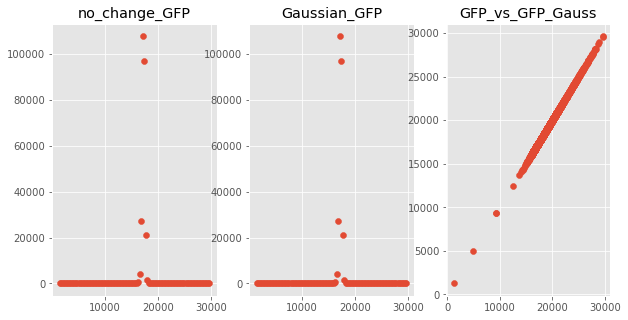

In [8]:
### displaying differences
f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize = (10,5))

time = 7
hist, bins = np.histogram(quickaggre(pos, time, gfp_images)[pos][time].ravel(), 100)
ax1.set_title('no_change_GFP')
ax1.scatter(bins[1:], hist)

hist, bins = np.histogram(quickaggre(pos, time, gfp_images)[pos][time].ravel(), 100)
ax2.set_title('Gaussian_GFP')
ax2.scatter(bins[1:], hist)

ax3.set_title('GFP_vs_GFP_Gauss')
ax3.scatter(quickaggre(pos, time, gfp_images)[pos][time].ravel(), quickaggre(pos, time, gfp_images)[pos][time].ravel())

In [9]:
# making a dataframe that has position and time
l = list()
failpos = list()
for pos in bf_images.keys(): # all positions should be the same so can use bf_images or rfp_images
    for time in bf_images[pos].keys(): # just getting the same keys of time
        l.append([pos,time])
pos_time_df = pd.DataFrame(l)
pos_time_df.columns = ['pos', 'time'] # dataframe that will have position and time for each variable 
pos_time_df = pos_time_df.sort_values(['pos', 'time'], ascending=[True, True]) # sort by position and time


In [10]:
def netzstack (time, pos, mask, netbf, shift):
    """this function is to work with cell count code, time represents the time in the loop with position 
    needed to pull out the name of the file, shift refers to how we align the image to the reference image"""
    zstacklist = []

    data =  np.load(netbf[pos][time])
    data = data['pixels']
    for i in range(0,data.shape[0],1):
        img = data[i,:,:,1].copy()
        alginimgbf= np.roll(img, int(shift[0]), axis = 0)# switched out unaliginbf 
        img1 = np.roll(alginimgbf, int(shift[1]), axis = 1)

        img1[~mask] = 0
        # putting it through our filters 
        x = img1  > threshold_otsu(img1)#np.std(img1) *3
        x = skimage.morphology.erosion(clear_border(x))
        x =remove_small_objects(x, min_size=200) # to remove the tiny objects so we can get better edges  
        sr = np.sum(x)
        zstacklist.append([i,sr])
     
    zstacknp = np.array(zstacklist ) 
    zstackmax = np.max(zstacknp[:,1])

    znumb = zstacknp[:,1].argsort()[-3:][::-1] # selecting for the best 3 
       #summing best 3
    unalignbf= np.zeros((3,512,512))
    n = 0
    for z in znumb:  
        unalignbf[n,:,:]= data[z,:,:,1] # filling in numpy array will only have 3 best zstacks 
        n = n+1
    unalignbf = np.sum(unalignbf, axis = 0)
    #alginimgBF = np.sum(unalignbf, axis = 0)
    alginimgbf = np.roll(unalignbf, int(shift[0]), axis = 0)# switched out unaliginbf 
    alginimgBF = np.roll(alginimgbf, int(shift[1]), axis = 1)
    return alginimgBF 

In [11]:
# Gaussian Mixture Model
from sklearn.mixture import GaussianMixture
from sklearn import mixture

def gausmix(df,mask):
    """This is to calculate the GFP max using Gaussian mixture model,
    df will be your aligned GFP or RFP followed by the mask which will be the maskquant
    Afterwords we pick the highest mean avalible """
    
    X =   df[mask].reshape(df[mask].shape[0],1) # turn it into a 2D array but really 1D 806, 1 example
    gmm = mixture.GaussianMixture(n_components=2).fit(X) 
    maxgmm = np.max(gmm.means_)
    mingmm = np.min(gmm.means_)
    return maxgmm, mingmm  # returns the mixture component greatest min

In [12]:
import torch 
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
 
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image

In [13]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device('cpu')

print('device used {}'.format(device))

device used cpu


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#https://theaisummer.com/unet-architectures/

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True))

    def forward(self, x):
        x = self.conv(x)
        return x


class InConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(InConv, self).__init__()
        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class Up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(Up, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)

        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class OutConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

class Unet(nn.Module):
    def __init__(self, in_channels, classes):
        super(Unet, self).__init__()
        self.n_channels = in_channels
        self.n_classes =  classes

        self.inc = InConv(in_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256)
        self.up2 = Up(512, 128)
        self.up3 = Up(256, 64)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x
    
model = Unet(1,2) # 1 is for how many channels 2 is for how many it outputs i said 2, loading empty model

unetpath = '/genomesvr1/home/michael/Hao_li/Yeast_aging/Pipeline_cell_Tracking/'
name = 'UNET_2Reborn512_512'#'UNET_512_512' #'MCunet2'# loading in the model name
model.load_state_dict(torch.load(unetpath+'/{}.pth'.format(name), map_location={'cuda:0': 'cpu'})) # to load model with cpu
model.to(device) # will turn model for GPU or CPU depending on the device stated above

# loading in the allcell unet model
model2 = Unet(1,2)
name2 = 'Allcellsv3_UNET_512_512' # 
model2.load_state_dict(torch.load(unetpath+'/{}.pth'.format(name2), map_location={'cuda:0': 'cpu'})) # to load model with cpu
model2.to(device) # will turn model for GPU or CPU depending on the device stated above
#model.eval()

Unet(
  (inc): InConv(
    (conv): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): Down(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(

In [15]:
from scipy import ndimage
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from skimage import morphology

def laplace_of_gaussian(gray_img, sigma=1., kappa=0.75, pad=False):
    """
    Applies Laplacian of Gaussians to grayscale image.

    :param gray_img: image to apply LoG to
    :param sigma:    Gauss sigma of Gaussian applied to image, <= 0. for none
    :param kappa:    difference threshold as factor to mean of image values, <= 0 for none
    :param pad:      flag to pad output w/ zero border, keeping input image size
    """
    assert len(gray_img.shape) == 2
    img = cv2.GaussianBlur(gray_img, (0, 0), sigma) if 0. < sigma else gray_img
    img = cv2.Laplacian(img, cv2.CV_64F)
    rows, cols = img.shape[:2]
    # min/max of 3x3-neighbourhoods
    min_map = np.minimum.reduce(list(img[r:rows-2+r, c:cols-2+c]
                                     for r in range(3) for c in range(3)))
    max_map = np.maximum.reduce(list(img[r:rows-2+r, c:cols-2+c]
                                     for r in range(3) for c in range(3)))
    # bool matrix for image value positiv (w/out border pixels)
    pos_img = 0 < img[1:rows-1, 1:cols-1]
    # bool matrix for min < 0 and 0 < image pixel
    neg_min = min_map < 0
    neg_min[1 - pos_img] = 0
    # bool matrix for 0 < max and image pixel < 0
    pos_max = 0 < max_map
    pos_max[pos_img] = 0
    # sign change at pixel?
    zero_cross = neg_min + pos_max
    # values: max - min, scaled to 0--255; set to 0 for no sign change
    value_scale = 255. / max(1., img.max() - img.min())
    values = value_scale * (max_map - min_map)
    values[1 - zero_cross] = 0.
    # optional thresholding
    if 0. <= kappa:
        thresh = float(np.absolute(img).mean()) * kappa
        values[values < thresh] = 0.
    log_img = values.astype(np.uint8)
    if pad:
        log_img = np.pad(log_img, pad_width=1, mode='constant', constant_values=0)
    return log_img

def seltopbf(mask,shift,bf_images,pos,time, numb =2 ):
    '''Using laplacian absolute mean to identify which zstack gives the best cell boarders
    i find that using the first 2 zstacks gives a good quality image vs 3 or 5.
    In this case the cell boarders are picked by tracking the individual mother cell'''
    l = []
    index = 0
    mask2 = mask.copy()
    mask = ndi.binary_dilation(mask, iterations=15)
    newbfarray = np.zeros((numb,512,512))
    for zfile in bf_images[pos][time]:
        index = index+1
        image = skimage.io.imread(zfile)
        image = np.roll(image, int(shift[0]), axis = 0)
        image = np.roll(image, int(shift[1]), axis = 1)
    
        image[~mask] = 0 # turn all but the cells designated in the mask into 0
        #lapvar = cv2.Laplacian(image, cv2.CV_64F, ksize=3) # peform laplacian, assuming images are 64
        #lapvar = np.abs(lapvar).mean() # to get the local max and min. IRRELEVANT IF it is negative 
        lapedge = laplace_of_gaussian(image, sigma=1., kappa=0.75, pad=False)
        lapvar = cv2.Laplacian(image, cv2.CV_16U, ksize=3)#.var()  
        lapvar = np.abs(lapvar).mean()#np.square(lapvar).mean()
    
        l.append({'z': index,'lapvar':lapvar,'file': zfile})
    zlist= pd.DataFrame(l).sort_values('lapvar', ascending = False)['file'][:numb].values # getting the top 5 based on the highest laplacian value
    for numb, zfile in enumerate(zlist):
        newbfarray[numb,:,:] = skimage.io.imread(zfile)
    newbfarray = np.sum(newbfarray, axis = 0) 
    newbfarray = np.roll(newbfarray, int(shift[0]), axis = 0) # shifting it back to the correct state
    newbfarray = np.roll(newbfarray, int(shift[1]), axis = 1)# shifting it back to the correct state
    
    return newbfarray
def watershedmask2(output, maskquant= None, prev_area= None, eccentricity= None):
    '''Here I am applying watershed to the outputted model, this will help further seperate cells that may be 
    super close to each other or any other mother cell'''
    if prev_area is None:
        prev_area = 600
        eccentricity = .5
        maskquant =output > np.mean(output) +(np.std(output) *1.2)
    output = (output - np.min(output)) / (np.max(output) - np.min(output)) # normalize the image for thresholding
    maskdilated = ndi.binary_dilation(maskquant, iterations=80) # dilating the previous maskquant by 100 to get neighbooring cells
    threshlist = np.arange(1.2, 5 , 0.1) # creating a threshold list that goes up by .1
    l = []
    output2 = output.copy()
    output2[~maskdilated] = 0
    for thresh in threshlist:
        mask = output2 > ( np.mean(output2) +(thresh*np.std(output2)))
        distance = ndimage.distance_transform_edt(mask)
        local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)), labels=mask)
        markers = morphology.label(local_maxi)
        labels_ws = watershed(-distance, markers, mask=mask)
        labels_ws[~maskdilated] = 0 # focusing on the specific cell region
        if (labels_ws > 0).any(): # to ensure there is no blank images
            #dic = skimage.measure.regionprops_table( (labels_ws),properties=('label', 'area', 'eccentricity')) 
            #df = pd.DataFrame(dic)
            roi_sum = np.sum(maskquant*labels_ws) # which has the best overlap with our mask 
            #df = df.loc[(df ['area'] > (prev_area*.3)) & (df['eccentricity'] <= (1.2*eccentricity)) &(df ['area'] < (prev_area *1.5))] # filtering out small particles and things that are not too circular 
            l.append([thresh , roi_sum])
    df = pd.DataFrame(l)
    df.columns = ['threshold', 'numbs']
     
    
    # using the better threshold  to make the new labels with watershed
    threshold = df.sort_values('numbs', ascending = False).iloc[0]['threshold']  # sorting for which gives the most amount of cells
    mask = output > ( np.mean(output) +(threshold*np.std(output)))
    distance = ndimage.distance_transform_edt(mask)
    local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)), labels=mask)
    markers = morphology.label(local_maxi)
    labels_ws = watershed(-distance, markers, mask=mask)
  
        
    return labels_ws

def watershedmask2(output, maskquant= None, prev_area= None, eccentricity= None):
    '''Here I am applying watershed to the outputted model, this will help further seperate cells that may be 
    super close to each other or any other mother cell'''
    if prev_area is None:
        prev_area = 600
        eccentricity = .5
        maskquant =output > np.mean(output) +(np.std(output) *1.2)
    output = (output - np.min(output)) / (np.max(output) - np.min(output)) # normalize the image for thresholding
    maskdilated = ndi.binary_dilation(maskquant, iterations=80) # dilating the previous maskquant by 100 to get neighbooring cells
    threshlist = np.arange(1.2, 6 , 0.1) # creating a threshold list that goes up by .1
    l = []
    output2 = output.copy()
    output2[~maskdilated] = 0
    maskquantsobel = np.sum(sobel(maskquant))
    areamask = 0 # mask of the different masks
    for thresh in threshlist:
        mask = output2 > ( np.mean(output2) +(thresh*np.std(output2)))
        roi_sum = np.sum(maskquant*mask)
        if (roi_sum > 0): # to ensure there is no blank images
            label2 = skimage.morphology.label(mask)
            prev_sum = -1
            best_sum = 0
            for i in np.unique(label2):
                if i == 0:  # is the background so we get rid of it
                    continue

                mask2 = label2 == i # selecting the mask of the previous frame 
                roi_sum = np.sum(maskquant*mask2) # multiplying the masks to shift it 
                newarea = np.sum(mask2)
                if (roi_sum > prev_sum ) :
                    best_sum = roi_sum
                    prev_sum =roi_sum
                    cellboundry = np.sum(sobel(mask2))
                    areamask = np.sum(mask2)

                else:
                    cellboundry = np.sum(sobel(mask2))
                    areamask = np.sum(mask2)

            l.append([thresh , best_sum, areamask,cellboundry])
            best_sum = 0

    df = pd.DataFrame(l)
    df.columns = ['threshold', 'overlap_area', 'areamask','sobel']
    
    if np.sum(df['overlap_area']) >0:   
        threshold = df.sort_values('overlap_area', ascending = False).iloc[0]['threshold']  # sorting for which gives the most amount of cells
    else: # usually required because the masks are not super aligned
        threshold = df.loc[df['areamask']<= (1.2*prev_area)] # 
        threshold = df.loc[df['sobel']<= (1.1*maskquantsobel)]
        threshold = threshold.sort_values('sobel', ascending = False).iloc[0]['threshold']

 
    mask = output2 > ( np.mean(output2) +(threshold*np.std(output2)))
 
 
    return mask


def watershedmask(output, maskquant= None, prev_area= None, eccentricity= None):
    '''Here I am applying watershed to the outputted model, this will help further seperate cells that may be 
    super close to each other or any other mother cell'''
    if prev_area is None:
        prev_area = 600
        eccentricity = .5
        maskquant =output > np.mean(output) +(np.std(output) *1.2)
    output = (output - np.min(output)) / (np.max(output) - np.min(output)) # normalize the image for thresholding
    maskdilated = ndi.binary_dilation(maskquant, iterations=80) # dilating the previous maskquant by 100 to get neighbooring cells
    threshlist = np.arange(1.2, 6 , 0.1) # creating a threshold list that goes up by .1
    l = []
    output2 = output.copy()
    output2[~maskdilated] = 0
    maskquantsobel = np.sum(sobel(maskquant))
    areamask = 0 # mask of the different masks
    for thresh in threshlist:
        mask = output2 > ( np.mean(output2) +(thresh*np.std(output2)))
        roi_sum = np.sum(maskquant*mask)
        if (roi_sum > 0): # to ensure there is no blank images
            label2 = skimage.morphology.label(mask)
            prev_sum = -1
            best_sum = 0
            for i in np.unique(label2):
                if i == 0:  # is the background so we get rid of it
                    continue

                mask2 = label2 == i # selecting the mask of the previous frame 
                roi_sum = np.sum(maskquant*mask2) # multiplying the masks to shift it 
                newarea = np.sum(mask2)
                if (roi_sum > prev_sum ) and (roi_sum < (1.2* prev_area) ) and (roi_sum> (.85*prev_area)) and (newarea> (.75*prev_area))and (newarea<(1.3* prev_area)):
                    best_sum = roi_sum
                    prev_sum =roi_sum
                    cellboundry = np.sum(sobel(mask2))
                    areamask = np.sum(mask2)

                else:
                    cellboundry = np.sum(sobel(mask2))
                    areamask = np.sum(mask2)

            l.append([thresh , best_sum, areamask,cellboundry])
            best_sum = 0

    df = pd.DataFrame(l)
    df.columns = ['threshold', 'overlap_area', 'areamask','sobel']


    # using the better threshold  to make the new labels with watershed
    if np.sum(df['overlap_area']) >0:   
        threshold = df.sort_values('overlap_area', ascending = False).iloc[0]['threshold']  # sorting for which gives the most amount of cells
    else: # usually required because the masks are not super aligned
        threshold = df.loc[df['areamask']<= (1.2*prev_area)] # 
        threshold = df.loc[df['sobel']<= (1.1*maskquantsobel)]
        threshold = threshold.sort_values('sobel', ascending = False).iloc[0]['threshold']

    mask = output2 > ( np.mean(output2) +(threshold*np.std(output2)))
    newmaskarea =np.sum(mask)
 
    #distance = ndimage.distance_transform_edt(mask)
    #local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)), labels=mask)
    #markers = morphology.label(local_maxi)
    #mask = watershed(-distance, markers, mask=mask)
    mask = morphology.label(mask)
    return mask


def watershedmask(mask):
    '''Here I am applying watershed to the outputted model, this will help further seperate cells that may be 
    super close to each other or any other mother cell'''
    distance = ndimage.distance_transform_edt(mask)
    local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)), labels=mask)
    markers = morphology.label(local_maxi)
    mask = watershed(-distance, markers, mask=mask)

    return mask

def watershedmaskapply(mask, prev_area, roi_mask1):
    '''mask is the unet model output, prev_roi is the previous one and label1 is the previously labeled image'''
    label2 =  watershedmask(mask)
    # Filter out between labels
    dflabel = pd.DataFrame(skimage.measure.regionprops_table( (label2),properties=('label', 'area', 'eccentricity', 'centroid', 'coords'))).set_index('label')
    #roi_mask1 = label1 == prev_roi
    roi_original = roi_mask1.copy()
    best_roi = -1
    best_sum = 0

    labels = set(dflabel.index) # in case you only have 1 elemetn 
    labels.add(0) # add a 0
    for i in labels:
        if i == 0:  # is the background so we get rid of it
            continue
        if len(regionprops(label2))>0 : # to remove any frame that has no cells 
            roi_mask2 = label2 == i # selecting the mask of the previous frame 
            roi_sum = np.sum(roi_original*roi_mask2) # multiplying the masks to shift it 
            if roi_sum > best_sum:
                best_sum = roi_sum
                best_roi = i
                
    maskquant = label2 == best_roi # the mask used to pick the cell we want 
    maskquant2 = maskquant #scipy.ndimage.morphology.binary_dilation(maskquant, iterations=1)# change if you want to get more of the cell. initially used to get that
    area = np.sum(maskquant)
    circle = dflabel.loc[best_roi,'eccentricity']
    mask = label2
    
    return best_roi,mask, maskquant, maskquant2, area, circle, label2, dflabel 


In [16]:
def findnewmothercell(bfimage, model_sel, label1, prev_roi):
    '''purpose is to find the new mask based on the previous one
    bfimage- this is your aggregated image of the either the best image or mix with a range of 0-1 pixels
    model_sel- which unet model will be used
    label1- the previous binary image that has your selected mask labeled
    prev_roi- the corrosponding mask of label1 will need this to identify it
    returns: mask, maskquant, maskquant2, area, circle, best_roi, label2, dflabel 
        mask- will be the predicted binary output of the UNET model
        maskquant- the selected mother cell of the time
        area- the area of the maskquant 
        circle- the eccentricty of the mask
        best_roi- which label corrosponds to the labeled unet mask 
        label2- the labeled mask with the corrosponding coordinates of each cell
        dflabel- dataframe housing a bunch of information for each cell 
    example: mask, maskquant, area, circle, best_roi, label2, dflabel  = findnewmothercell(bfimage, model_sel, label1, prev_roi)'''
    bftensor = transform(bfimage.astype(np.float32)) # must be np.float32 or else unet WILL not accept it
    with torch.no_grad(): # will speed it up
        predict = model_sel(bftensor.to(device).view(-1,1, 512,512)).to('cpu').detach().numpy() # getting all cells 
    pred = predict[0,1,:,:].reshape(512,512) # the outputed image of UNET
   
    blanknp = np.zeros((512,512)) # make a blank image
    contours = find_contours(pred, .5)  # draw the contour 
    for contour in contours:
        blanknp[np.round(contour[:, 0]).astype('int'), np.round(contour[:, 1]).astype('int')] = 1
    mask = ndimage.binary_fill_holes(blanknp) # fill in any holes 
 
    # here we are setting up the previous mask and the current mask 
    label2 = skimage.morphology.label(mask)

    # Filter out between labels
    dflabel = pd.DataFrame(skimage.measure.regionprops_table( (label2),properties=('label', 'area', 'eccentricity', 'centroid', 'coords'))).set_index('label')
 
    roi_mask1 = label1 == prev_roi
    best_roi = -1
    best_sum = 0
    labels = set(dflabel.index) # in case you only have 1 elemetn 
    labels.add(0) # add a 0
    for i in labels:
        if i == 0:  # is the background so we get rid of it
            continue
        if len(regionprops(label2))>0 : # to remove any frame that has no cells 
            roi_mask2 = label2 == i # selecting the mask of the previous frame 
            roi_sum = np.sum(roi_mask1*roi_mask2) # multiplying the masks to shift it 
            if roi_sum > best_sum:
                best_sum = roi_sum
                best_roi = i
    if best_roi > -1:
        maskquant = label2 == best_roi # the mask used to pick the cell we want 
        area = np.sum(maskquant)
        circle = dflabel.loc[best_roi,'eccentricity']
    else:
        maskquant = label2 == best_roi
        area = np.sum(maskquant)
        circle = None
    return mask, maskquant, area, circle, best_roi, label2, dflabel 

In [ ]:
'Calculating max intensity for GFP and RFP of each individual cell. This will take the position and time into account'
# making a dataframe that will be used for position and time 
import time as Time
from skimage.morphology import remove_small_objects
from skimage.measure import find_contours
import scipy.ndimage as ndimage
from scipy import ndimage as ndi
import pylab
from skimage.segmentation import flood 
import cv2
import numpy as np
 
gfplist = []
gfp_sumlist = []
gfpGMmaxlist = []
gfpGMminlist = []
gfplistori = []
gfp_sumlistori = []
gfpGMmaxlistori = []
gfpGMminlistori = []
rfplist = []
rfpsumlist = []
rfpGMmaxlist = []
rfpGMminlist = []
failpos = []
areamasklist = []
proteinarealist = []
failrfp =[]
infolist = []
redolist = []
countfailarea = 0
transform = transforms.ToTensor() # for transformation
for pos in sorted(bf_images.keys()):
    # creating unique labels
    referenceimg = None
    
    # identify the top 2 zstacks 
    index =0
    zlistl = []
    for zfile in bf_images[pos][1]: # for the first time
        index = index+1
        image = skimage.io.imread(zfile)
        lapedge = laplace_of_gaussian(image, sigma=1., kappa=0.75, pad=False)
        lapvar = cv2.Laplacian(image, cv2.CV_16U, ksize=3)#.var()  
        lapvar = np.abs(lapvar).mean()#np.square(lapvar).mean()
        zlistl.append({'z': index,'laplase_sum': np.sum(lapedge) ,'lapvar':lapvar,'file': zfile})
    
    newbflapvar = np.zeros((2,512,512))
    zlist= pd.DataFrame(zlistl).sort_values('lapvar', ascending = False)['file'][:2].values # getting the top 3 based on the highest laplacian value
    for numb, zfile in enumerate(zlist):
        newbflapvar[numb,:,:] = skimage.io.imread(zfile) # load in the top 2 zstacks
    bfimage1 = np.sum(newbflapvar, axis = 0) ## brightfiled laplacian
    bfimage = (bfimage1 - np.min(bfimage1))/(np.max(bfimage1)- np.min(bfimage1))# normalize merged zstacks to 0-1
    bftensor = transform(bfimage.astype(np.float32)) # turn into tensor format 
    with torch.no_grad(): # will speed it up
        predict = model2(bftensor.to(device).view(-1,1, 512,512) ).to('cpu').detach().numpy() # turn back to numpy array

    pred = predict[0,1,:,:].reshape(bfimage1.shape) ## resize the image back to 512X512 from [1,1,512,512]
    blanknp = np.zeros((512,512))
    contours = find_contours(pred, .5) 
    for contour in contours:
        blanknp[np.round(contour[:, 0]).astype('int'), np.round(contour[:, 1]).astype('int')] = 1
    mask = ndimage.binary_fill_holes(blanknp)
    #mask =  ndi.binary_fill_holes(ndi.binary_closing(mask))
    mask = remove_small_objects(mask, min_size=270)
    maskori = mask  > (np.mean(mask ) +np.std(mask ))#ndi.binary_dilation(ndi.gaussian_filter(mask, sigma = 1), iterations=1)

    reflabel = skimage.morphology.label(maskori) # labeling the mask
 
    for mother in np.unique(reflabel): # all mother cells found are based on RFP first time point
        if mother == 0: # is the background so we get rid of it
            continue
 
        prev_roi = mother
        prev_mask = None
        referenceimg = None
        prev_area = None
        mask = maskori # we need to blank the mask back to the original so that every cell is referenced back to the original mask. can't do later as it backfires!
        maskquant= None # blanking for future
        
        for time in sorted( rfp_images[pos].keys()):

            if referenceimg is None: # making all images to align to the reference image of 1
                referenceimg = 'filled'#quickaggre(pos, 1 , rfp_images, False)[pos][1] #rfp_aggre[pos][1].copy()
                referenceimgbfp = quickaggre(pos, 1 , bf_images, False)[pos][1]  #using the first image as a reference point to help with alignment
                continue 

            # shifting and aligning the next images
                     # Shifting GFP alignment 
            unalignbf = quickaggre(pos, time , bf_images, False)[pos][time]  
            shift, error, diffphase = register_translation(referenceimgbfp, unalignbf, 1000)# using original bf_aggre to calculate shift
            alginimgbf = np.roll(unalignbf, int(shift[0]), axis = 0)# switched out unaliginbf 
            alginimgBF = np.roll(alginimgbf, int(shift[1]), axis = 1) # aligining image back to reference point
            
            # shifting RFP
            unalignrfp = quickaggre(pos, time , rfp_images, False)[pos][time] 
            alginimgrfp = np.roll(unalignrfp, int(shift[0]), axis = 0)
            alginimgRFP =  np.roll(alginimgrfp, int(shift[1]), axis = 1)# aligining image back to reference point

            # Shifting GFP alignment 
            unaligngfp = quickaggre(pos, time, gfp_images, False, True)[pos][time] 
            alginimggfp = np.roll(unaligngfp, int(shift[0]), axis = 0)
            alginimgGFP = np.roll(alginimggfp, int(shift[1]), axis = 1)# aligining image back to reference point
            
             # Shifting original GFP alignment 
            unaligngfpori = quickaggre(pos, time, gfp_images, False)[pos][time] 
            alginimggfpori = np.roll(unaligngfpori, int(shift[0]), axis = 0)
            alginimgGFPori = np.roll(alginimggfpori, int(shift[1]), axis = 1)# aligining image back to reference point
                 
            
            if prev_mask is None: # First frame WILL be used only!
                maskquant = reflabel == mother
                maskquant2 = maskquant
                prev_mask = mask # setting up the first original mask to restart each time
                area = np.sum(maskquant)
                prev_area = np.sum(maskquant) # for starting cells 
                precircle= .57 # 
                circle = .57
                #continue
            
            else:
                bfimage1 = seltopbf(maskquant,shift,bf_images,pos,time, numb =2 ) # sum of the best 2 brightfield images via lapvar
                bfimage = (bfimage1 - np.min(bfimage1))/(np.max(bfimage1)-np.min(bfimage1))# normalize merged zstacks to 0-1
                bftensor = transform(bfimage.astype(np.float32)) # must be np.float32 or else unet WILL not accept it
                 
                with torch.no_grad(): # will speed it up
                    predict = model2(bftensor.to(device).view(-1,1, 512,512)).to('cpu').detach().numpy() # getting all cells 
                pred = predict[0,1,:,:].reshape(512,512)
                #mask = watershedmask(pred,maskquant, prev_area,precircle ) # will apply a threshold and watershed to get the new cells
                blanknp = np.zeros((512,512))
                contours = find_contours(pred, .5) 
                for contour in contours:
                    blanknp[np.round(contour[:, 0]).astype('int'), np.round(contour[:, 1]).astype('int')] = 1
                mask = ndimage.binary_fill_holes(blanknp)
                #mask = watershedmask(mask)
            
            # here we are setting up the previous mask and the current mask 
            if len(np.unique(prev_mask))==2: # in case watershed was not implemented
                label1 = skimage.morphology.label(prev_mask) # NDI label
            else: # if watershed is implemented it is alrady labled no need to redo it
                label1 = prev_mask
            label2 = skimage.morphology.label(mask)
            
            # Filter out between labels
            dflabel = pd.DataFrame(skimage.measure.regionprops_table( (label2),properties=('label', 'area', 'eccentricity', 'centroid', 'coords'))).set_index('label')
            #dflabel = dflabel.loc[(dflabel ['area'] > (prev_area*.3)) &(dflabel ['area'] < (prev_area *1.5))] # Filtering out bad labels
            
            roi_mask1 = label1 == prev_roi
            best_roi = -1
            best_sum = 0
            
            labels = set(dflabel.index) # in case you only have 1 elemetn 
            labels.add(0) # add a 0
            for i in labels:
                if i == 0:  # is the background so we get rid of it
                    continue
                if len(regionprops(label2))>0 : # to remove any frame that has no cells 
                    roi_mask2 = label2 == i # selecting the mask of the previous frame 
                    roi_sum = np.sum(roi_mask1*roi_mask2) # multiplying the masks to shift it 
                    if roi_sum > best_sum:
                        best_sum = roi_sum
                        best_roi = i

                        #prev_roi = best_roi
            # checking to make sure the mask is the best one and if the frame didn't go blank 
            if (best_roi > 0) or (best_roi <0):
                #maskquant= label2 == best_roi
                    # making the mask
                try:
                    maskquant = label2 == best_roi # the mask used to pick the cell we want 
                    maskquant2 = maskquant #scipy.ndimage.morphology.binary_dilation(maskquant, iterations=1)# change if you want to get more of the cell. initially used to get that
                    area = np.sum(maskquant)
                    if best_roi> -1:
                        circle = dflabel.loc[best_roi,'eccentricity']
                    else:
                        circle = 0

                    if (time <4 )and (prev_area >800) or (prev_area <280): # in case initial masks picks two cells and we need to dump it
                        prev_area = area

                    #watershed if area is still too big
                    if (area> (1.15 *prev_area) ):
                        best_roi, mask,maskquant, maskquant2, area, circle, label2, dflabel = watershedmaskapply(mask, prev_area, roi_mask1 )
                        #mask = maskquant
                        #best_roi = 1


                    # using the model again but using the best two zstacks based on ALL cells not just where the area of mask is 
                    if (area> (1.2 *prev_area) ) or (area< (.90 *prev_area) ): # using area and eccentricty to remove bad mothers
                        #bfimage1 = seltopbf(maskquant,shift,bf_images,pos,time, numb =4) # sum of the best 2 brightfield images via lapvar
                        indextry =0
                        l = []
                        for zfile in bf_images[pos][time]:
                            index = indextry+1
                            image = skimage.io.imread(zfile)
                            lapedge = laplace_of_gaussian(image, sigma=1., kappa=0.75, pad=False)
                            lapvar = cv2.Laplacian(image, cv2.CV_16U, ksize=3)#.var()  
                            lapvar = np.abs(lapvar).mean()#np.square(lapvar).mean()
                            l.append({'z': indextry,'laplase_sum': np.sum(lapedge) ,'lapvar':lapvar,'file': zfile})

                        newbflapvar = np.zeros((2,512,512))
                        #newmasklapvar = np.zeros((2,512,512))
                        zlist= pd.DataFrame(l).sort_values('lapvar', ascending = False)['file'][:2].values # getting the top 5 based on the highest laplacian value
                        for numb, zfile in enumerate(zlist):
                            newbflapvar[numb,:,:] = skimage.io.imread(zfile)
                            #newmasklapvar[numb,:,:] = skimage.io.imread(zfile.replace('c1', 'c{}'.format(cytochannel)))
                        bfimage1 = np.sum(newbflapvar, axis = 0) ## brightfiled laplacian
                        bfimage1 = np.roll(bfimage1, int(shift[0]), axis = 0)# switched out unaliginbf 
                        bfimage1 = np.roll(bfimage1, int(shift[1]), axis = 1) # aligining image back to reference point
                        bfimage = (bfimage1 - np.min(bfimage1))/(np.max(bfimage1)-np.min(bfimage1))# normalize merged zstacks to 0-1

                        # redoing the mask identification 
                        mask, maskquant, area, circle, best_roi, label2, dflabel  = findnewmothercell(bfimage, model2, label1, prev_roi)
                        maskquant2 = maskquant

                        #watershed 2 to check if area is still too big
                        if (area> (1.15 *prev_area) ):
                            best_roi,mask,maskquant, maskquant2, area, circle, label2, dflabel = watershedmaskapply(mask, prev_area,roi_mask1 )
                            #mask = maskquant
                            #best_roi = 1
                    # if Area is too small reimplement UNET but edit other parts of the image
                    if (area< (.85 *prev_area) ):
                        maskquant = ndi.binary_dilation(maskquant, iterations=50)
                        bfimage1[~maskquant] = ndi.gaussian_filter(bfimage1[~maskquant], sigma = 8) # filter nearby area
                        bfimage = (bfimage1 - np.min(bfimage1))/(np.max(bfimage1)-np.min(bfimage1))# normalize merged zstacks to 0-1
                        # reimplmenting model 
                        mask, maskquant, area, circle, best_roi, label2, dflabel  = findnewmothercell(bfimage, model2, label1, prev_roi)
                        maskquant2 = maskquant

                        # redo watershed in case image is too big
                        if (area> (1.15 *prev_area) ) :
                            best_roi,mask, maskquant, maskquant2, area, circle, label2, dflabel = watershedmaskapply(mask, prev_area,roi_mask1 )
                            #mask = maskquant
                            #best_roi = 1

                    # using the mother finder model 
                    if (area> (1.4 *prev_area) ) or (area< (.75 *prev_area) ) and (((best_sum/np.sum(roi_mask1))*100)< 70) :
                        maskquant = label1 == prev_roi # using the previous mask 
                        bfimage1 = seltopbf(maskquant,shift,bf_images,pos,time, numb =8 ) # repeat but get the best 7 zstacks
                        bfimage = (bfimage1 - np.min(bfimage1))/(np.max(bfimage1)-np.min(bfimage1))# normalize merged zstacks to 0-1

                        #implementing the UNET Mother finder model
                        mask, maskquant, area, circle, best_roi, label2, dflabel  = findnewmothercell(bfimage, model , label1, prev_roi)
                        maskquant2 = maskquant

                        redolist.append([str(pos) + '_cell_' +str(mother), pos, time, area ])
                except:
                    pass 

                    # using previous mask
                try:
                    if (area> (1.2 *prev_area) ) or (area< (.85 *prev_area) ) or (np.sum(label2 == best_roi) <= 1):#(area> (1.2 *prev_area) ) or (area< (.85 *prev_area) ) or (circle> (precircle *1.7)) or (np.sum(label2 == best_roi) <= 1):  # changed from 1.2 eccentricity to 1.7
                        maskquant = label1 == prev_roi # switching out to the previous mask which is label1 with the previous roi
                        best_roi = prev_roi
                        mask = prev_mask
                        circle = precircle

                        dflabel = prev_dflabel#pd.DataFrame(skimage.measure.regionprops_table( (label1),properties=('label', 'area', 'eccentricity', 'centroid', 'coords'))).set_index('label')
                        failpos.append([str(pos) + '_cell_' +str(mother), pos, time, area ])

                    maskquant2 = maskquant #scipy.ndimage.morphology.binary_dilation(maskquant, iterations=2) # to get the RFP signal
                    area = np.sum(maskquant)


                except:
                    pass 
        

            if best_roi < 0:
                failpos.append([str(pos) + '_cell_' +str(mother), pos, time, area ])
                

           #calculating the values
            position = 'pos' + '_'+ str(pos) + '_cell_' +str(mother)
            timepoint = time
            

            rfp_pixmax = np.max(alginimgRFP[maskquant2])
            rfp_pixsum = np.sum(alginimgRFP[maskquant2])
            #rfp_pixGMmax, rfp_pixGMmin =gausmix(alginimgRFP,maskquant2)# gaussian mixture function
            
            gfp_pixmax = np.max(alginimgGFP[maskquant])
            gfp_pixsum = np.sum(alginimgGFP[maskquant])
            #gfp_pixGMmax, gfp_pixGMmin = gausmix(alginimgGFP,maskquant)# gaussian mixture function
            
            gfp_pixmaxori = np.max(alginimgGFPori[maskquant])
            gfp_pixsumori = np.sum(alginimgGFPori[maskquant])
            #gfp_pixGMmaxori, gfp_pixGMminori = gausmix(alginimgGFPori,maskquant)

            gfplist.append([position,timepoint,gfp_pixmax])
            gfp_sumlist.append([position,timepoint,gfp_pixsum])
            #gfpGMmaxlist.append([position,timepoint,gfp_pixGMmax])# mean max pixel after Gaus mixture model
            #gfpGMminlist.append([position,timepoint,gfp_pixGMmin])
            
            gfplistori.append([position,timepoint,gfp_pixmaxori])
            gfp_sumlistori.append([position,timepoint,gfp_pixsumori])
            #gfpGMmaxlistori.append([position,timepoint,gfp_pixGMmaxori])# mean max pixel after Gaus mixture model
            #gfpGMminlistori.append([position,timepoint,gfp_pixGMminori])
            
            rfplist.append([position,timepoint,rfp_pixmax])# max
            rfpsumlist.append([position,timepoint,rfp_pixsum]) # sum
            #rfpGMmaxlist.append([position,timepoint,rfp_pixGMmax]) # mean max pixel after Gaus mixture model
            #rfpGMminlist.append([position,timepoint,rfp_pixGMmin])
                #calculating cell area and how much space a protein or organelle is occupying            
            proteinarea = alginimgGFP.copy()
            try:
                proteinarea = proteinarea> threshold_otsu(proteinarea[maskquant]) # also servers as a normalize comparing 0,1
            except:
                pass
            proteinarea  = np.sum(proteinarea[maskquant]) # pixel NOT being measured it is sum of TRUEs
            
            proteinarealist.append([position,timepoint,proteinarea])
            areamasklist.append([position,timepoint,area]) # for cell
            
            if best_roi == -1: # for the infodf 
                dflabel = prev_dflabel#pd.DataFrame(skimage.measure.regionprops_table( (label1),properties=('label', 'area', 'eccentricity', 'centroid', 'coords'))).set_index('label')
                
            infolist.append([position, timepoint, area, shift,circle , dflabel.loc[best_roi,'centroid-0'],dflabel.loc[best_roi,'centroid-1'], dflabel.loc[best_roi,'coords']])

            if (best_roi > 0): # best roi will be -1 if the label2 has a shitty image
                prev_roi = best_roi # to replace 
                prev_mask = mask
                prev_area = area
                precircle = circle 
                prev_dflabel = dflabel


            #if time > 15: 
             #   print(mother)
              #  break
end = Time.time()
print((end-start)/60, 'minutes to run')
    
del referenceimg, referenceimgbfp, unalignbf, unalignrfp,unaligngfp,unaligngfpori

In [18]:
# function to make a dataframe with Ease
def makedf(dflist):
    df = pd.DataFrame(dflist)
    df.columns = ['position', 'time', 'value']
    df = df.sort_values('time')
    df = df.pivot(index = 'time', columns='position')['value']
    df1 = df.sort_index()
    return df1

In [19]:
infodf = pd.DataFrame(infolist)
 
infodf.columns = ['position', 'time', 'area', 'shift', 'eccentricity', 'circle_center_x', 'circle_center_y', 'coords']
infodf = infodf.set_index('position')
infodf['date'] = bf_images[list(bf_images.keys())[0]][1][0].split('/')[-2]


In [20]:
## MAX RFP
rfpdf = makedf(rfplist)
## SUM RFP
rfpsumdf = makedf(rfpsumlist)

## Max using Gaussian
#rfpGMmaxdf =  makedf(rfpGMmaxlist)
#rfpGMmindf =  makedf(rfpGMminlist)
## MAX GFP
gfpdf = makedf(gfplist)
gfpdfori = makedf(gfplistori)
## sum GFP
gfpsumdf = makedf(gfp_sumlist)
gfpsumdfori = makedf(gfp_sumlistori)

## Max  and min using Gaussian
#gfpGMmaxdf =  makedf(gfpGMmaxlist)
#gfpGMmaxdfori =  makedf(gfpGMmaxlistori)
#gfpGMmindfori= makedf(gfpGMminlistori)
#gfpGMmindf =  makedf(gfpGMminlist)

## Area of cell
areamaskdf = makedf(areamasklist) #measures TRUE and False not PIXEL values !

## Area of protein occupying cell or organelle 
proteinareadf = makedf(proteinarealist) #measures TRUE and False not PIXEL values !

#calculating radius and Volume assuming it is sphere like 
radiusdf = np.sqrt((areamaskdf/(4*np.pi))) # pretenidng it is a sphere so we can get radius 
volumedf = (4/3)*(np.pi)*(radiusdf*radiusdf*radiusdf)


# normalizing for AREA
gfpmaxnorm = gfpdf/areamaskdf
gfpsumnorm = gfpsumdf/areamaskdf
gfpmaxnormori = gfpdfori/areamaskdf
gfpsumnormori = gfpsumdfori/areamaskdf

rfpmaxnorm = rfpdf/areamaskdf
rfpsumnorm = rfpsumdf/areamaskdf
   
# normalizing for volume 
gfpmaxvoln = gfpdf/volumedf
gfpsumvoln = gfpsumdf/volumedf
gfpmaxvolnori = gfpdfori/volumedf
gfpsumvolnori = gfpsumdfori/volumedf

rfpmaxvolnm = rfpdf/volumedf
rfpsumvolnrm = rfpsumdf/volumedf


# collecting all the failed frames and its positions 
    # outputs two columns position and time, for the masks that failed 
 

failposdf = pd.DataFrame(failpos)
failposdf.columns = ['position','pos', 'time', 'area']
 

redodf = pd.DataFrame(redolist)
redodf.columns = ['position','pos', 'time', 'area']
 

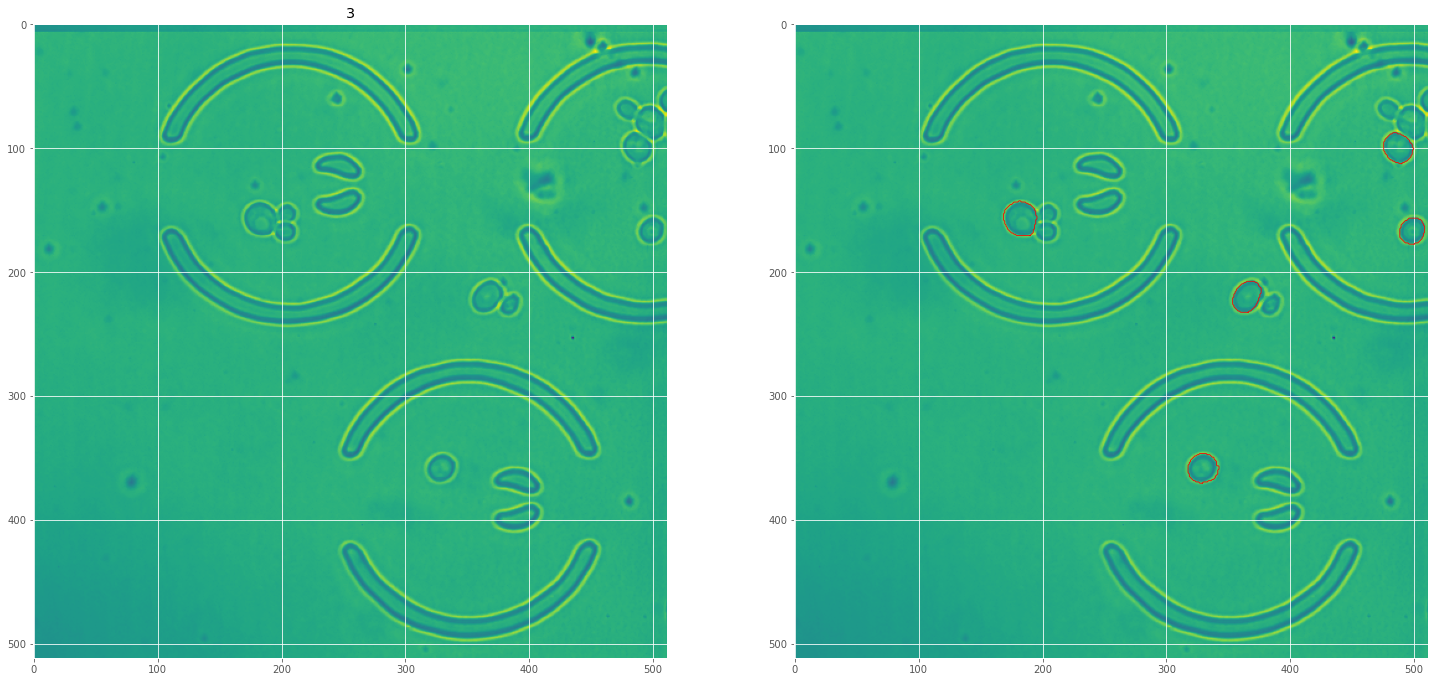

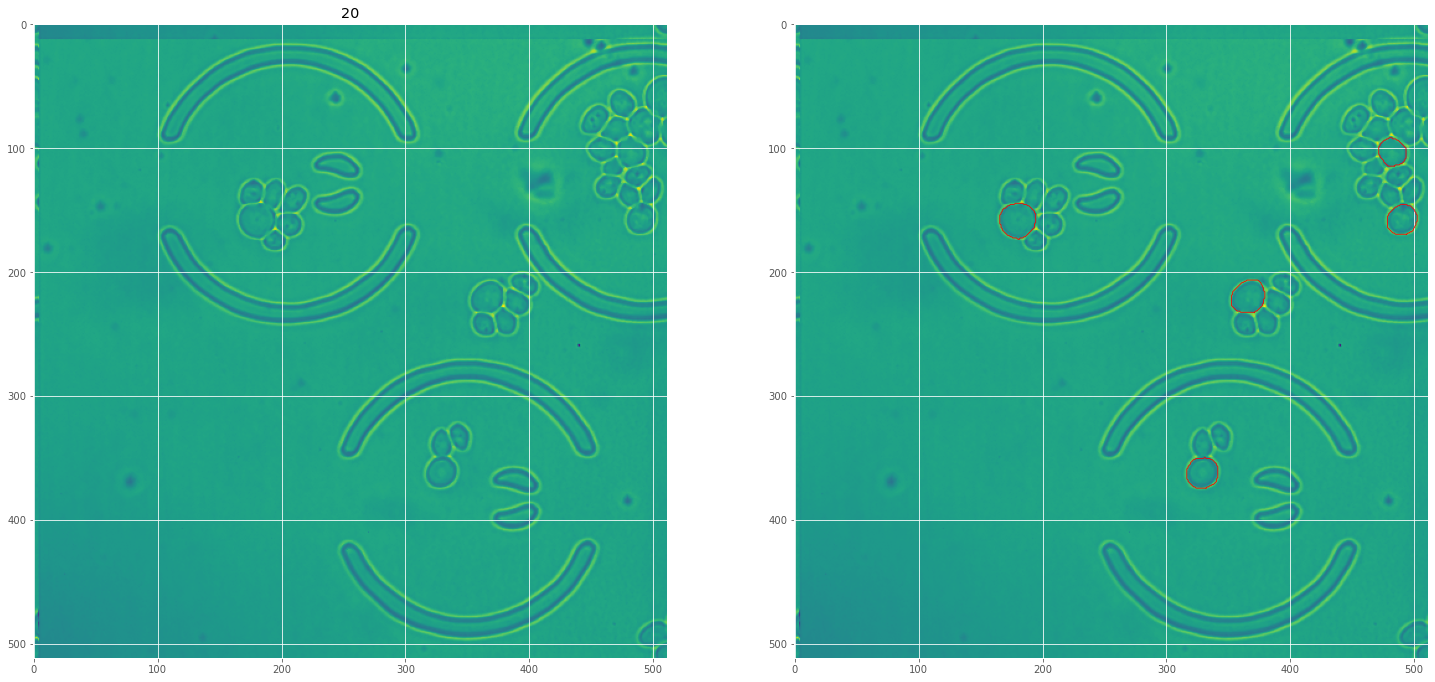

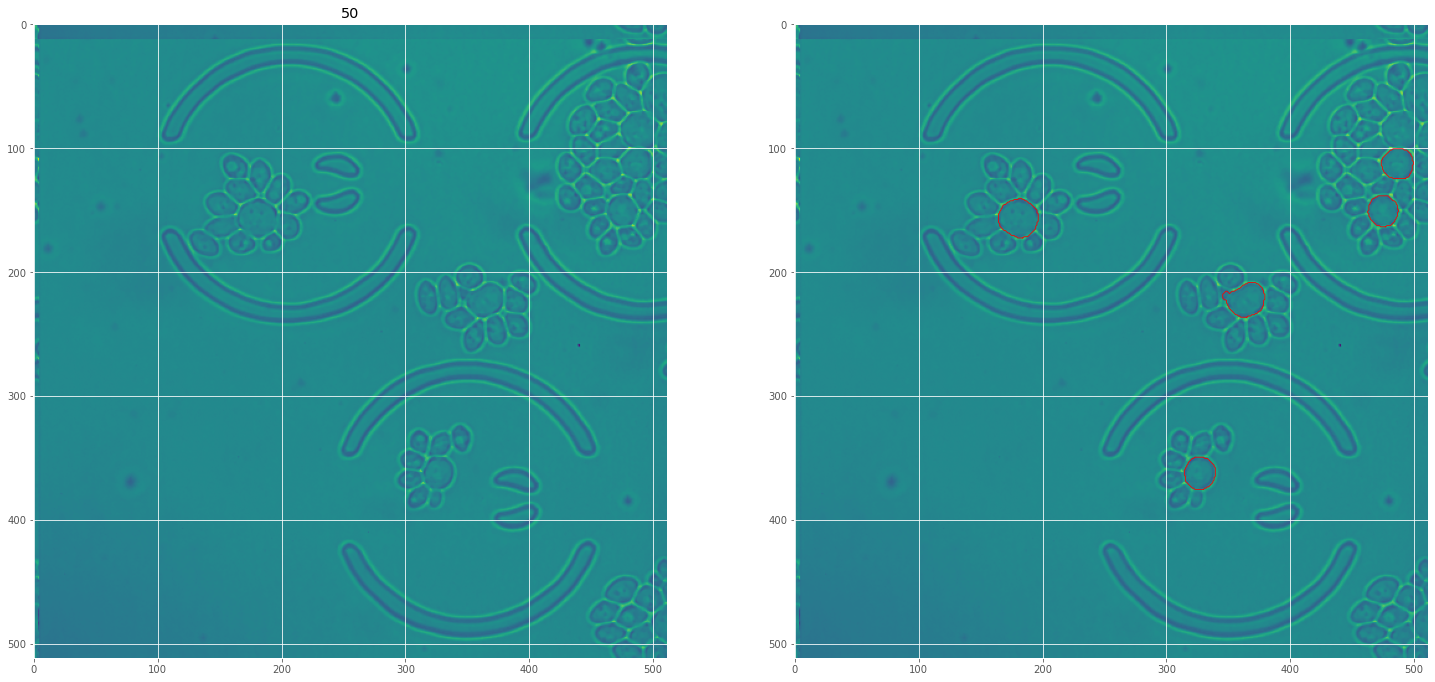

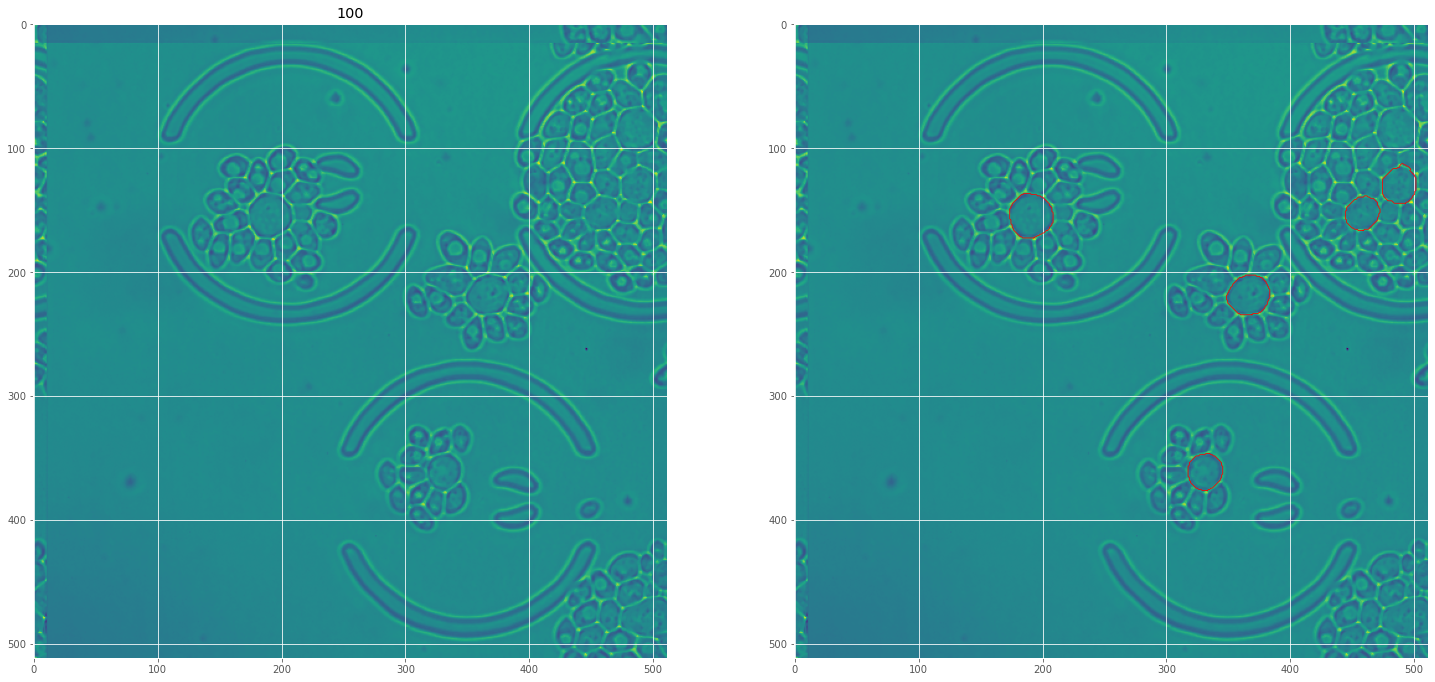

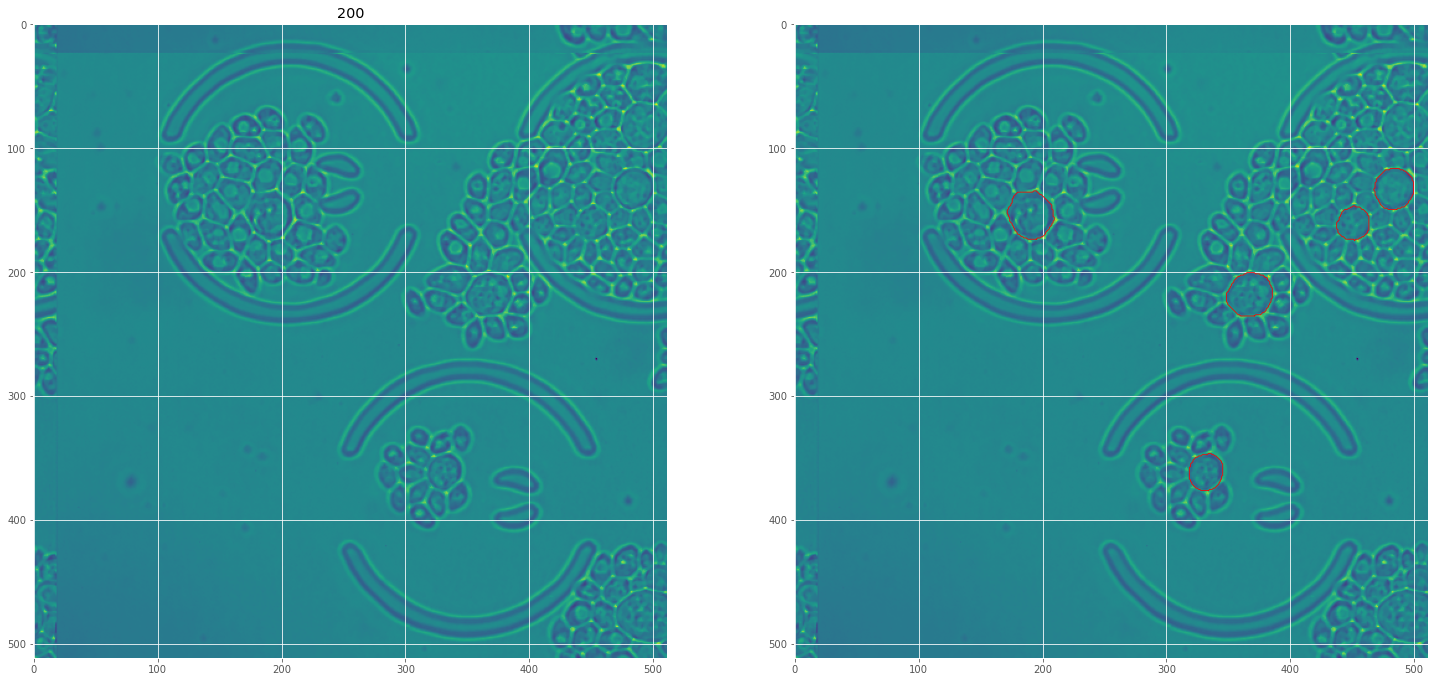

In [59]:
pos = '007'

l = []
infodf1 = infodf.reset_index()
infodf1 = infodf1.groupby(by = ['position', 'time']) # grouping by name 

for cell in infodf.reset_index()['position']:
    if cell.startswith('pos_'+pos +'_'):
        l.append(cell)
cells = set(l)
for time in [3, 20,50,100,200]:#infodf['time'].unique():
    df = np.zeros((512,512))
    for name in cells:

        infodf2 = infodf1.get_group((name, time))

        poly = infodf2['coords'].iloc[0]

        df[poly[:, 0], poly[:, 1]] = 1
    f, (ax1, ax2 ) = plt.subplots(1,2, figsize = (25,25))
    shift = infodf2['shift'].values[0]
    bf = seltopbf(df,shift,bf_images,pos,time, numb =2 )
    #rfp = quickaggre(pos, time , rfp_images, False)[pos][time] 
    #bf= np.roll(bf, int(shift[0]), axis = 0)
    #bf = np.roll(bf, int(shift[1]), axis = 1)
    #rfp = np.roll(rfp, int(shift[0]), axis = 0)
    #rfp = np.roll(rfp, int(shift[1]), axis = 1)
    ax1.imshow(bf)
    #thresh = np.mean(rfp) +np.std(rfp)*3
    #ax2.imshow(rfp > thresh)
    ax2.imshow(bf)
    ax1.set_title(time)
    contours = find_contours(df, .5) # finds the corresponding peaks and draws it on the picture
    for contour in contours:
        ax2.plot(contour[:, 1], contour[:, 0], linewidth=.8, color='r')
    plt.show()
 

In [ ]:
for pos in infodf.index.unique():
    plt.plot(infodf.loc[pos, 'time'],infodf.loc[pos, 'area'])
    plt.title(pos)
    plt.show()

# BACkground test

In [23]:
import time as Time
# using netbf to stat where we subtract 
backmedianls = []
backmeanls = []  
backmedianls_RFP = []
backmeanls_RFP = []  

start = Time.time()
for pos in bf_images.keys():
    for time in bf_images[pos].keys():
        # loading files 
        bf = quickaggre(pos, time, bf_images)[pos][time]
        #Providing Threshold to remove real signal such as cells and the wells 
        bf = ((bf - np.min(bf))/(np.max(bf)- np.min(bf)))*255 # normalize the BF
        mean = np.mean(bf)
        sd = np.std(bf) *1.2
        thre = mean - sd
        sob = sobel(bf > thre)
 
        
        bm = scipy.ndimage.morphology.binary_dilation(sob, iterations=15) #dilate in case sobel missed anything
        
        gfpbackground1 = quickaggre(pos, time, gfp_images)[pos][time]
        gfpbackground1[bm] = 0  # turning all the cells found in the mask to 0 to remove them out
        gfpbackground = gfpbackground1[gfpbackground1 != 0]
        
        #rfp subtraction 
        rfpbackground1= quickaggre(pos, time, rfp_images)[pos][time]
        rfpbackground1[bm] = 0  # turning all the cells found in the mask to 0 to remove them out
        rfpbackground = rfpbackground1[rfpbackground1 != 0]
        
        # for GFP background subraction dataframe
        backmedianls.append([time,pos, np.median(gfpbackground)])
        backmeanls.append([time,pos, np.mean(gfpbackground)])
        
        # for RFP background subtraction 
        backmedianls_RFP.append([time,pos, np.median(rfpbackground)])
        backmeanls_RFP.append([time,pos, np.mean(rfpbackground)])        
        
        del bf, gfpbackground, rfpbackground

end = Time.time()
print((end-start)/60)

67.33640716870626


In [24]:
# turning list of backgroound into a dataframe
# for GFP 
df = pd.DataFrame(backmeanls) 
df.columns = ['time', 'position', 'values']
df = df.pivot(index = 'time', columns = 'position')['values']
backmeandf = df.loc[3:,:]

df = pd.DataFrame(backmedianls) 
df.columns = ['time', 'position', 'values']
df = df.pivot(index = 'time', columns = 'position')['values']
backmediandf =  df.loc[3:,:]

# for RFP 
df = pd.DataFrame(backmeanls_RFP) 
df.columns = ['time', 'position', 'values']
df = df.pivot(index = 'time', columns = 'position')['values']
backmeanls_RFPdf = df.loc[3:,:]

df = pd.DataFrame(backmedianls_RFP) 
df.columns = ['time', 'position', 'values']
df = df.pivot(index = 'time', columns = 'position')['values']
backmedianls_RFPdf =  df.loc[3:,:]  

In [25]:
date = bf_images[list(bf_images.keys())[0]][1][0].split('/')[-2] # Adding the date 
backmeandf.to_pickle(outfilename +str("backmeandfgfp_" +str(date)+".pkl")) 
backmediandf.to_pickle(outfilename +str("backmediandfgfp_" +str(date)+".pkl")) 

backmeanls_RFPdf.to_pickle(outfilename +str("backmeandfrfp_" +str(date)+".pkl")) 
backmedianls_RFPdf.to_pickle(outfilename +str("backmediandfrfp_" +str(date)+".pkl")) 

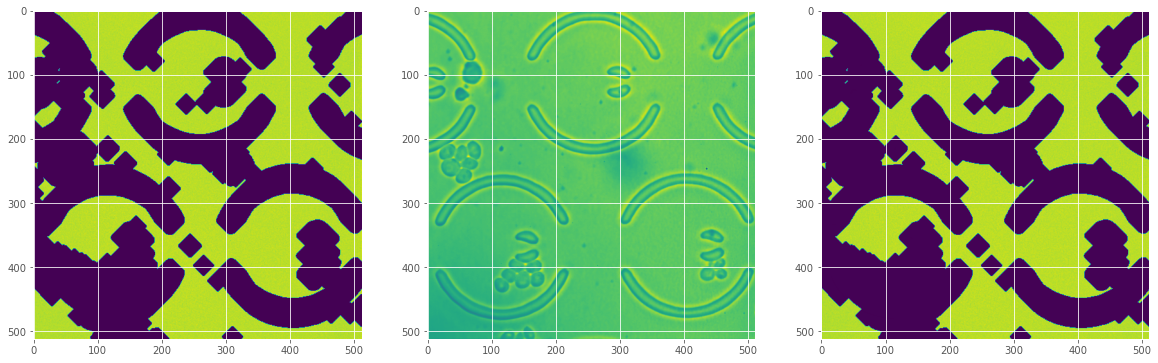

In [26]:
pos = '015'
time = 20
bf = quickaggre(pos, time, bf_images)[pos][time]

 
#BF
bf = ((bf - np.min(bf))/(np.max(bf)))*255 # normalize the BF


mean = np.mean(bf)
sd = np.std(bf) *1.2
thre = mean - sd
sob = sobel(bf > thre)


#netbf

 
    
bm = scipy.ndimage.morphology.binary_dilation(sob, iterations=15)#dilate in case sobel missed anything
#bm = ndimage.gaussian_filter(bm, sigma = 10)

gfpbackground1 = quickaggre(pos, time, gfp_images)[pos][time]
gfpbackground1[bm] = 0  # turning all the cells found in the mask to 0 to remove them out
gfpbackground = gfpbackground1[gfpbackground1 != 0]

#rfp subtraction 
rfpbackground1= quickaggre(pos, time, rfp_images)[pos][time]
rfpbackground1[bm] = 0  # turning all the cells found in the mask to 0 to remove them out
rfpbackground = rfpbackground1[rfpbackground1 != 0]

# for GFP background subraction dataframe
backmedianls.append([time,pos, np.median(gfpbackground)])
backmeanls.append([time,pos, np.mean(gfpbackground)])

# for RFP background subtraction 
backmedianls_RFP.append([time,pos, np.median(rfpbackground)])
backmeanls_RFP.append([time,pos, np.mean(rfpbackground)])  

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (20,20))

ax1.imshow(rfpbackground1)
ax2.imshow(bf)
ax3.imshow(bf+rfpbackground1)



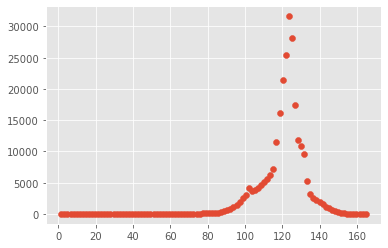

In [27]:
hist, bins = np.histogram(bf, 100)
plt.scatter(bins[1:], hist)

In [28]:
def backsub(background, dataframe):
    dfmerge = pd.DataFrame(index = background.index)
    for col in background.columns:
        colcell = 'pos_' +str(col)+'_'
        collist = dataframe.columns.str.startswith(colcell)
        df1 = dataframe.loc[:,collist]
        df2 = df1.sub(background[col], axis='index')
        dfmerge = dfmerge.merge(df2, on = 'time', how = 'outer')
    return dfmerge

In [29]:
# subtracting background from dataframes of GFPsum and GFPgmMAX
    # each position has a specifc background range so I am subtracting it
gfpsumMeanback = backsub(backmeandf, gfpsumdf)
gfpsumMedback = backsub(backmediandf, gfpsumdf)  

#gfpsumMeanGMMAXback = backsub(backmeandf, gfpGMmaxdf)
#gfpsumMedGMMAXback = backsub(backmediandf, gfpGMmaxdf) 

In [30]:
# purpose to get the mean of several time points, and get the range between them
def convunorm(data,dist, add = None):
    """data is ur df that has the GFP or RFP calculations dist refers to the number range you want to calculate mean
    function will output the mean of time ranges, you can pick them by CHANGING dist,
    add is a LIST for 1 or more numbers represents if you want to put any other positions that were previously missing"""
    if dist != None:
        l = list()
        x  = data.rolling(dist).mean()  # this will basically perform a convulsion of the number dist u put, the firt will have NAS
        #min and max of your dataframe times
        mintime = np.min(data.index.values)
        maxtime = np.max(data.index.values)
        if add != None:
            if len(add) == 1:
                l.append(x.loc[add[0],:])
            else:
                for i in add: # MUST BE IN LIST FORM
                    l.append(x.loc[i,:])
        for num in range(mintime,maxtime, dist):
            l.append(x.iloc[num,:]) # pulling out the range number 
        mean_matrix = pd.concat(l, axis = 1).T.dropna()
    else:
        mean_matrix = data 
        
    return mean_matrix.sort_index() 

 
 

# Graphing and viewing Correlations
Playing with Data. Below I have inputs to make graphs to show GFP and RFP correlations as well as a accumulation of the calculated averages. Furthermore, I also have animations below 

In [31]:
timeused = pd.Series(gfpdf.iloc[:,1].index)

In [32]:
# calculating cell correlation to time
corrdf = list()
date = bf_images[list(bf_images.keys())[0]][1][0].split('/')[-2] # Adding the date 

for col in gfpdf.columns:
    m,b, r, p, sd = linregress(gfpdf.loc[:,col], rfpdf.loc[:,col])
    m,b, r2, p, sd = linregress(gfpdf.loc[:,col], timeused)
    ma,ba, r2a, pa, sda = linregress(areamaskdf.loc[:,col], timeused)
    mag,bag, r2ag, pag, sdag = linregress(areamaskdf.loc[:,col], gfpdf.loc[:,col])
    spear, pvalue = scipy.stats.spearmanr(gfpdf.loc[:,col], timeused) # calculating spearman of GFP overtime
    
    if '001' in col or '002' in col or '003' in col or '004' in col:
        strain = 'cox4_dt_rpn11'
    if '005' in col or '006' in col or '007' in col or '008' in col or '009' in col or '010' in col or '011' in col:
        strain = 'cox4_dt_rpn11'
    if '012' in col or '013' in col or '014' in col :
        strain ='cox4_dt_rpn11'
        
    if  '015' in col or '016' in col or '017' in col or '018' in col or '019' in col or '020' in col:
        strain = 'cox4_dt_vma1'
    if '021' in col or '022' in col or '023' in col or '024' in col:
        strain = 'cox4_dt_vma1'
    if '025' in col or '026' in col or '027' in col or '028' in col:
        strain = 'cox4_dt_vma1'
        
    if '029' in col or '030' in col or '031' in col or '032' in col or '033' in col:
        strain = 'cox4_dt_vma1'
        
    corrdf.append([date,strain, col, r, r2, spear,r2a,r2ag])
    
# turning it into a dataframe
r2timedf = pd.DataFrame(corrdf)
r2timedf.columns = ['date', 'strain', 'position', 'R2_gfp_rfp', 'R2_GFP_time', 'spear_GFP_time','R2_area_time', 'R2_area_gfpmax' ]
r2timedf['name'] = r2timedf['position'].astype(str) + '_'+r2timedf['strain'].astype(str) # adding strain name

# adding some key columns to the infodf file 
infodf = pd.merge(r2timedf, infodf, on = ['position', 'date']).drop(columns = ['R2_gfp_rfp', 'R2_GFP_time','spear_GFP_time', 'R2_area_time','R2_area_gfpmax'])
infodf['name2'] =  infodf['date']+'_'+infodf['name']

## making a dictionary that houses a list of the positions of strains
straindic = {}
for strain in r2timedf['strain'].unique():
    straindic[strain] = r2timedf.loc[r2timedf['strain'] == strain, 'position'].tolist()

In [33]:
## calculating the average Correlation for each strain
    # previously we have calculated the correlation between GFP and time for each individual cell
    # now i want to know what is the average correlation between each individual cells as well as the variation and mean
l = list()
for strain in r2timedf['strain'].unique():
    mean = np.mean(r2timedf.loc[r2timedf['strain']== strain]['R2_GFP_time'])
    meanspear = np.mean(r2timedf.loc[r2timedf['strain']== strain]['spear_GFP_time'])
    sd = np.std(r2timedf.loc[r2timedf['strain']== strain]['R2_GFP_time'])
    number = r2timedf.loc[r2timedf['strain']== strain]['R2_GFP_time'].shape[0] 

    l.append([strain, mean, meanspear, sd, number])
    
avercorrdf = pd.DataFrame(l)
avercorrdf.columns = ['strain', 'mean_R2', 'meanspearman', 'standared_deviation', 'cell_number']
    

In [34]:
avercorrdf

,strain,mean_R2,meanspearman,standared_deviation,cell_number
0,cox4_dt_rpn11,0.226678,0.232888,0.459734,71
1,cox4_dt_vma1,-0.223333,-0.198053,0.424426,69


# Saving Files

In [35]:
import pickle
import bz2
 
infodf.to_pickle(outfilename +str("infodf_" +str(date)+".pkl"))
#gfpGMmindf.to_pickle(outfilename +str("gfpGMmindf_" +str(date)+".pkl"))
#gfpGMmindfori.to_pickle(outfilename +str("gfpGMmindfori_" +str(date)+".pkl"))
#rfpGMmindf.to_pickle(outfilename +str("rfpGMmindf_" +str(date)+".pkl"))

rfpdf.to_pickle(outfilename +str("rfpdf_" +str(date)+".pkl"))
rfpsumdf.to_pickle(outfilename +str("rfpsumdf_" +str(date)+".pkl"))
#rfpGMmaxdf.to_pickle(outfilename +str("rfpGMmaxdf_" +str(date)+".pkl"))
gfpdf.to_pickle(outfilename +str("gfpdf_" +str(date)+".pkl"))
gfpdfori.to_pickle(outfilename +str("gfpdfori_" +str(date)+".pkl"))
gfpsumdf.to_pickle(outfilename +str("gfpsumdf_" +str(date)+".pkl"))
gfpsumdfori.to_pickle(outfilename +str("gfpsumdfori_" +str(date)+".pkl"))
#gfpGMmaxdf.to_pickle(outfilename +str("gfpGMmaxdf_" +str(date)+".pkl"))
#gfpGMmaxdfori.to_pickle(outfilename +str("gfpGMmaxdfori_" +str(date)+".pkl"))
proteinareadf.to_pickle(outfilename +str("proteinareadf_" +str(date)+".pkl"))
areamaskdf.to_pickle(outfilename +str("areamaskdf_" +str(date)+".pkl"))
radiusdf.to_pickle(outfilename +str("radiusdf_" +str(date)+".pkl"))
volumedf.to_pickle(outfilename +str("volumedf_" +str(date)+".pkl"))
gfpmaxnorm.to_pickle(outfilename +str("gfpmaxnorm_" +str(date)+".pkl"))
gfpsumnorm.to_pickle(outfilename +str("gfpsumnorm_" +str(date)+".pkl"))
gfpmaxnormori.to_pickle(outfilename +str("gfpmaxnormori_" +str(date)+".pkl"))

gfpsumnormori.to_pickle(outfilename +str("gfpsumnormori_" +str(date)+".pkl"))
rfpmaxnorm.to_pickle(outfilename +str("rfpmaxnorm_" +str(date)+".pkl"))
rfpsumnorm.to_pickle(outfilename +str("rfpsumnorm_" +str(date)+".pkl"))
gfpmaxvoln.to_pickle(outfilename +str("gfpmaxvoln_" +str(date)+".pkl"))  
gfpsumvoln.to_pickle(outfilename +str("gfpsumvoln_" +str(date)+".pkl")) 
gfpmaxvolnori.to_pickle(outfilename +str("gfpmaxvolnori_" +str(date)+".pkl"))  
gfpsumvolnori.to_pickle(outfilename +str("gfpsumvolnori_" +str(date)+".pkl"))  
rfpmaxvolnm.to_pickle(outfilename +str("rfpmaxvolnm_" +str(date)+".pkl"))  
rfpsumvolnrm.to_pickle(outfilename +str("rfpsumvolnrm_" +str(date)+".pkl")) 
#straindic.to_pickle(outfilename +str("straindic_" +str(date)+".pkl"))
#countcellsdf.to_pickle(outfilename +str("countcellsdf_" +str(date)+".pkl"))

r2timedf.to_pickle(outfilename +str("r2timedf_" +str(date)+".pkl"))
avercorrdf.to_pickle(outfilename +str("avercorrdf_" +str(date)+".pkl"))


gfpsumMeanback.to_pickle(outfilename +str("gfpsumMeanback_" +str(date)+".pkl"))
gfpsumMedback.to_pickle(outfilename +str("gfpsumMedback_" +str(date)+".pkl"))

#gfpsumMeanGMMAXback.to_pickle(outfilename +str("gfpsumMeanGMMAXback_" +str(date)+".pkl"))
#gfpsumMedGMMAXback.to_pickle(outfilename +str("gfpsumMedGMMAXback_" +str(date)+".pkl")) 


backmeandf.to_pickle(outfilename +str("backmeandf_" +str(date)+".pkl")) 
backmediandf.to_pickle(outfilename +str("backmediandf_" +str(date)+".pkl")) 


 
failposdf.to_pickle(outfilename +str("failposdf_" +str(date)+".pkl")) 
redodf.to_pickle(outfilename +str("redodf_" +str(date)+".pkl")) 
 

# Z stack 
to get the max intensities and subtract background based on individual zstacks 

In [36]:
# Gaussian Mixture Model
from sklearn.mixture import GaussianMixture
from sklearn import mixture

def gausmix(df,mask):
    """This is to calculate the GFP max using Gaussian mixture model,
    df will be your aligned GFP or RFP followed by the mask which will be the maskquant
    Afterwords we pick the highest mean avalible """
    
    X =   df[mask].reshape(df[mask].shape[0],1) # turn it into a 2D array but really 1D 806, 1 example
    gmm = mixture.GaussianMixture(n_components=2).fit(X) 
    maxgmm = np.max(gmm.means_)
    mingmm = np.min(gmm.means_)
    return maxgmm, mingmm  # returns the mixture component greatest min

In [37]:
from sklearn.mixture import GaussianMixture
from sklearn import mixture

def baysGaus(df,mask):
    """This is to calculate the GFP max using Baysian gaussian ,
    df will be your aligned GFP or RFP followed by the mask which will be the maskquant
    Afterwords we pick the highest mean avalible """

    X =   df[mask].reshape(df[mask].shape[0],1) # turn it into a 2D array but really 1D 806, 1 example
    gmm = mixture.BayesianGaussianMixture(n_components=1).fit(X)
    maxgmm = np.max(gmm.means_)
    #mingmm = np.min(gmm.means_)
    return maxgmm  # returns the mixture component greatest min

In [38]:
# function to make a dataframe with Ease
def makedf(dflist):
    df = pd.DataFrame(dflist)
    df.columns = ['position', 'time', 'zstack', 'value']
    df = df.set_index(['time', 'zstack']) # multi index
    df =df.pivot(index = [df.index], columns = 'position')['value'] 
    return df


# function to make a dataframe with Ease
def makedf2(dflist):
    df = pd.DataFrame(dflist)
    df.columns = ['position', 'time', 'value']
    df = df.sort_values('time')
    df = df.pivot(index = 'time', columns='position')['value']
    df1 = df.sort_index()
    return df1

In [39]:
import scipy.ndimage as ndimage
from scipy import ndimage as ndi
def zstackpixelsumdf(df_images, bf_images, fdic):
    global gfpGMmaxdfori,gfpGMmindfori, gfpGMmaxareadf, gfpGMminareadf, gfpGMmaxsumdfori, gfpGMminsumdfori,gfpGMmaxcoordf, gfpGMmincoordf
 
    
    infodf = fdic['infodf']
    gfpGMmaxdfori = []
    gfpGMmindfori = []
    gfpGMmaxareadf = []
    gfpGMminareadf=[]
    gfpGMmaxsumdfori =[]
    gfpGMminsumdfori =[]
    gfpGMmaxcoordf =[]
    gfpGMmincoordf=[]
    for pos in sorted(df_images.keys()):
            for time in sorted(infodf['time'].unique()):
                infodf1 = infodf.set_index('position')# using the info file containg the mothers mask 
                cols = infodf1.loc[infodf1.index.str.startswith(('pos_'+str(pos), pos))].index.unique().values # get all or one of the column names
                if len(cols) != 0:
                    infodf1 = infodf1.reset_index()
                    infodf1 = infodf1.groupby(by = ['position', 'time']) # grouping by name 

                    infodf2 = infodf1.get_group((cols[0], time)) # every cell of the same position should have the same shift
                    shift = infodf2['shift'].values[0]

                    # for calculating background subtraction using brightfiled 
                    #bf = quickaggre(pos, time, bf_images)[pos][time] # load in SUM of all zstacks 

                    #Providing Threshold to remove real signal such as cells and the wells 
                    #bf = ((bf - np.min(bf))/(np.max(bf) - np.min(bf)))*255 # normalize the BF
                    #mean = np.mean(bf)
                    #sd = np.std(bf) *1.2
                    #thre = mean - sd
                    #sob = sobel(bf > thre)
                    #bm = scipy.ndimage.morphology.binary_dilation(sob, iterations=15) #dilate in case sobel missed anything

                    oripic512 = np.zeros((17,512,512))
                    for zstacknumber, z in enumerate(sorted(df_images[pos][time])):
                        zstacknumber = zstacknumber +1
                        img =skimage.io.imread(z,plugin='pil')  # reading in one z stack image at a time

                        # assigning pic an img 
                        pic = img.copy()  # no gaussian filter 
                        # shifting image to match the masks
                        pic = np.roll(pic, int(shift[0]), axis = 0)
                        pic = np.roll(pic, int(shift[1]), axis = 1)
                        oripic512[zstacknumber-1,:,:] = pic
                    oripic512 = np.sum(oripic512, axis = 0) # sum the zstacks
                    oripic512gaus = ndi.gaussian_filter(oripic512, sigma = 3.5 ) #blur the zstack

                    for col in cols:
                        if len(cols) <= 1: # for any positin columns that have only 1 cell 

                            col = cols[0]

                        df = np.zeros((512,512)) # empty image
                        infodf2 = infodf1.get_group((col, time))
                        poly = infodf2['coords'].iloc[0]
                        df[poly[:, 0], poly[:, 1]] = 1
                        pos = col.split('_')[1]
                        position = infodf2['position'].values[0]

                        mothercell = df > 0 


                        picmask = oripic512[mothercell] # specific region that has the cell mask

                        gfp_pixGMmaxori, gfp_pixGMminori = gausmix(oripic512gaus,mothercell) # the GAUSSin blured image is used to determine threshold
                        
                        gfpGMmaxmask = (oripic512>= gfp_pixGMmaxori) # use the original unedited image to determine pixel region
                        gfpGMminMask = (oripic512< gfp_pixGMmaxori)
                        
                        gfpGMmaxmask[~mothercell] = 0 # turn everything that is not the motehrcell to 0 need this so we can save the coordinates
                        gfpGMminMask[~mothercell] = 0 
                        
                        coord = np.where(gfpGMmaxmask)
                        coordinates = [(x,y) for x, y in zip(coord[0], coord[1])]
                        coordinatesmax = np.array(coordinates) # for the gaussian max value
                        
                        coord = np.where(gfpGMminMask)
                        coordinates = [(x,y) for x, y in zip(coord[0], coord[1])]
                        coordinatesmin = np.array(coordinates) # for the gaussin min value
                        
                        gfpGMmaxmask = gfpGMmaxmask[mothercell] # (oripic512[mothercell]>= gfp_pixGMmaxori) recentering mask so it fits the mothercell region of picmask 
                        gfpGMminMask = gfpGMminMask[mothercell] #(oripic512[mothercell]< gfp_pixGMmaxori)
                                            
                        
                        
                        # Gausmean
                        gfp_pixGMmaxori= picmask[gfpGMmaxmask].mean()
                        gfp_pixGMminori = picmask[gfpGMminMask].mean()
                        
                        #gauss sum of that region
                        gfp_pixGMmaxori_sum= picmask[gfpGMmaxmask].sum()
                        gfp_pixGMminori_sum = picmask[gfpGMminMask].sum()

                        # making list
                        gfpGMmaxcoordf.append([position,time, coordinatesmax ]) # where the gaussianmax is being made
                        gfpGMmincoordf.append([position,time, coordinatesmin ])
                        
                        
                        gfpGMmaxdfori.append([position,time, gfp_pixGMmaxori ]) # mean values 
                        gfpGMmindfori.append([position,time, gfp_pixGMminori ])
                        
                        gfpGMmaxsumdfori.append([position,time,gfp_pixGMmaxori_sum ]) # Sum of values
                        gfpGMminsumdfori.append([position,time,gfp_pixGMminori_sum])
                        
                        gfpGMmaxareadf.append([position,time, np.sum(gfpGMmaxmask)]) # area of the mask occupied 
                        gfpGMminareadf.append([position,time, np.sum(gfpGMminMask )])
                        
 



    # Turning it into a dataframe
    gfpGMmaxcoordf = makedf2(gfpGMmaxcoordf)
    gfpGMmincoordf = makedf2(gfpGMmincoordf)
    
    gfpGMmaxdfori = makedf2(gfpGMmaxdfori) 
    gfpGMmindfori = makedf2(gfpGMmindfori) 
    
    gfpGMmaxsumdfori = makedf2(gfpGMmaxsumdfori) 
    gfpGMminsumdfori = makedf2(gfpGMminsumdfori) 
    

    gfpGMmaxareadf = makedf2(gfpGMmaxareadf) 
    gfpGMminareadf = makedf2(gfpGMminareadf) 
    
    

In [40]:
import scipy.ndimage as ndimage
from scipy import ndimage as ndi
def zstackpixeldf(df_images, bf_images, fdic):
    'This will be used to calculate the values between'
    global gfpsumzstackori,  gfpsumzstackori, gfp_pixGMminzstackori, gfp_pixGMmaxzstackori, \
    proteinareazstackori,zstacklist,backmedianlszstackgfp, backmeanlszstackgfp, nzstackgfpGMax, nmedzstackgfpGMax, nzmaxstackgfpGMax,\
    bay5zstack, abovemean, above5mean, volume5, mcvolume5, volumezstack, gfpsumzstackorinorm, gfpsum5zstackorinorm,\
    gfpvolzstacknorm,gfpsumzstackmedarea, gfpmeanztackori, gfpGMmaxzstacktop4, gfpGMminzstacktop4
 
    gfpsumzstackori=[]
    gfpsumzstackori=[]
    gfp_pixGMmaxzstackori = []
    gfp_pixGMminzstackori=[]
    proteinareazstackori=[]
    zstacklist = []
    backmedianlszstackgfp= []
    backmeanlszstackgfp= []
    bay5zstack=[]
    abovemean=[]
    volume5 = []
    mcvolume5 = []
    volumezstack =[]
    gfpsumzstackorinorm =[]
    gfpsum5zstackorinorm =[]
    volthreshsumlist = []
    gfpmeanorignalist = []
    infodf = fdic['infodf']
    for pos in sorted(df_images.keys()):
        for time in sorted(infodf['time'].unique()):
            
            infodf1 = infodf.set_index('position')# using the info file containg the mothers mask 
            cols = infodf1.loc[infodf1.index.str.startswith(('pos_'+str(pos), pos))].index.unique().values # get all or one of the column names
            if len(cols) != 0:
                infodf1 = infodf1.reset_index()
                infodf1 = infodf1.groupby(by = ['position', 'time']) # grouping by name 

                infodf2 = infodf1.get_group((cols[0], time)) # every cell of the same position should have the same shift
                shift = infodf2['shift'].values[0]

                # for calculating background subtraction using brightfiled 
                bf = quickaggre(pos, time, bf_images)[pos][time] # load in SUM of all zstacks 
 
                #Providing Threshold to remove real signal such as cells and the wells 
                bf = ((bf - np.min(bf))/(np.max(bf) - np.min(bf)))*255 # normalize the BF
                mean = np.mean(bf)
                sd = np.std(bf) *1.2
                thre = mean - sd
                sob = sobel(bf > thre)
                bm = scipy.ndimage.morphology.binary_dilation(sob, iterations=15) #dilate in case sobel missed anything
                
 
                for zstacknumber, z in enumerate(sorted(df_images[pos][time])):
                    zstacknumber = zstacknumber +1
                    img =skimage.io.imread(z,plugin='pil')  # reading in one z stack image at a time

                    # assigning pic an img 
                    pic = img.copy()  # no gaussian filter 
                    # shifting image to match the masks
                    pic = np.roll(pic, int(shift[0]), axis = 0)
                    pic = np.roll(pic, int(shift[1]), axis = 1)
                    
                    pic2 = ndi.gaussian_filter(pic, sigma = 1.5) # bluring the image for filters to be used 
                    



                    # for GFP background subraction dataframe
                        # using above BM mask made to determine which values to get the mean and median of 
                    gfpbackground1 = img.copy()
                    gfpbackground1[bm] = 0  # turning all the cells found in the mask to 0 to remove them out
                    gfpbackground = gfpbackground1[gfpbackground1 != 0]
                    
                    # for Gaussian Mixture Model 
                    zimagegaus = pic.copy() #- np.median(gfpbackground) # subtract the median for the Guassian Mixture
                    #zimagegaus[zimagegaus<0] = 0 # turn all negatives to zero if they exist
                    zimagegaus = ndi.gaussian_filter(zimagegaus, sigma = 8) #Blur the image well 
                    
                 




                    for col in cols:
                        if len(cols) <= 1: # for any positin columns that have only 1 cell 
                            #if col == cols:
                            #    continue 
                            #else:
                            col = cols[0]

                        df = np.zeros((512,512)) # empty image
                        infodf2 = infodf1.get_group((col, time))
                        poly = infodf2['coords'].iloc[0]
                        df[poly[:, 0], poly[:, 1]] = 1
                        pos = col.split('_')[1]
                        position = infodf2['position'].values[0]

                        mothercell = df > 0 
                        gfpsumorignal = np.sum(pic[mothercell])
                        gfpmeanorignal = np.mean(pic[mothercell])

                        # outlining thresholds
                        gfp_pixGMmaxori, gfp_pixGMminori = gausmix(zimagegaus,mothercell)
                        #gfpbaymax= baysGaus(pic2,mothercell)
                        thresh = np.mean(pic2[mothercell]) +(np.std(pic2[mothercell])*1)



                        #thresh = pic2[mothercell][pic2[mothercell]>= thresh].mean()

                        # getting real values using the threshold
                        picmask = pic[mothercell]
                        gfp_pixGMmaxori = picmask[zimagegaus[mothercell]>=gfp_pixGMmaxori].mean()
                        gfp_pixGMminori = picmask[zimagegaus[mothercell]<gfp_pixGMmaxori].mean()
                        #gfpbaymax = picmask[pic2[mothercell]>=gfpbaymax].mean()
                        thresh = picmask[pic2[mothercell]>=thresh].mean()

                        # volume calculations 
                        #volthresh = volpic[mothercell] # median background subtracted negatives turned to 0 
                        #volthresh = np.mean(volthresh[volthresh>0]) # getting mean of all volume pixels EXCEPT FOR 0
                        #volpic [volpic < volthresh] =0 # turn all values less than the mean to 0 
                        volpic = pic - np.median(gfpbackground) # subrtract median values 
                        volpic[volpic<0] = 0

                        volpic = ndi.gaussian_filter(volpic, sigma = 1)# blur the imgae a bit to get volume
                        volpic = volpic[mothercell]
                        volumegfp = np.sum(volpic > np.mean(volpic)) # counting all NONZEROS 
                        
                        volthreshsum = picmask[(volpic > np.mean(volpic))].sum() # get sum of this mothercell 


                        proteinarea = pic.copy() 
                        proteinarea = proteinarea >= gfp_pixGMmaxori # also servers as a normalize comparing 0,1
                        proteinareaori  = np.sum(proteinarea[mothercell]) # pixel NOT being measured it is sum of TRUEs

                        # making list
                        gfpsumzstackori.append([position,time,zstacknumber,gfpsumorignal ])
                        
                        gfpmeanorignalist.append([position,time,zstacknumber,gfpmeanorignal])

                        gfp_pixGMmaxzstackori.append([position,time,zstacknumber,gfp_pixGMmaxori ])

                        gfp_pixGMminzstackori.append([position,time,zstacknumber,gfp_pixGMminori ])

                        proteinareazstackori.append([position,time,zstacknumber,proteinareaori ])

                        volume5.append([position,time,zstacknumber,volumegfp])
                        volthreshsumlist.append([position,time,zstacknumber,volthreshsum])
                        #zstacklist.append([position, time,zstacknumber, z ]) # to keep a list of the zstacks


                        ## new BAy and thresholds 
                        #bay5zstack.append([position,time,zstacknumber,gfpbaymax ])
                        abovemean.append([position,time,zstacknumber,thresh])

                        #Background dataframe made
                        backmedianlszstackgfp.append([position, time,zstacknumber, np.median(gfpbackground)])
                        backmeanlszstackgfp.append([position, time,zstacknumber, np.mean(gfpbackground)])
            else:
                print(pos)

    # Turning it into a dataframe
    gfpsumzstackori = makedf(gfpsumzstackori )
    gfp_pixGMmaxzstackori = makedf(gfp_pixGMmaxzstackori )
    gfp_pixGMminzstackori = makedf(gfp_pixGMminzstackori)
    proteinareazstackori = makedf(proteinareazstackori)
    #zstacklist = makedf(zstacklist)
    backmedianlszstackgfp = makedf(backmedianlszstackgfp)
    backmeanlszstackgfp = makedf(backmeanlszstackgfp)
    #bay5zstack = makedf(bay5zstack)
    abovemean = makedf(abovemean)
    volume5 = makedf(volume5)
    volumezstack = volume5.copy() # to get the volume of individual zstack 
    volthreshsumdf = makedf(volthreshsumlist)
    gfpmeanorignaldf = makedf(gfpmeanorignalist)
    # using mean background subtraction
    normzstack_gfpGMax = (gfp_pixGMmaxzstackori - backmeanlszstackgfp) 
    nzstackgfpGMax = normzstack_gfpGMax.groupby([ 'time']).sum() 
    
    #bay5zstack = (bay5zstack- backmeanlszstackgfp) # subtracting background 
    abovemean =(abovemean - backmeanlszstackgfp) # subtracting background 
    mcvolume5 = volume5
    
    # picking top best 5 
    df = pd.DataFrame(index = infodf['time'].unique())
    df1 = pd.DataFrame(index = infodf['time'].unique())
    df2= pd.DataFrame(index = infodf['time'].unique())
    for time in df.index:
        for col in abovemean.columns:
            indexgfp = abovemean.loc[time].sort_values(col, ascending = False)[col].iloc[0:5].index # using same indexes
            df.loc[time,col] = abovemean.loc[time].loc[indexgfp, col].sum() # for top 5 above mean
            df1.loc[time,col] = volume5.loc[time].loc[indexgfp, col].sum() # for top 5 volume5 
            df2.loc[time,col] = normzstack_gfpGMax.loc[time].loc[indexgfp, col].sum() # for top 5 volume5
    above5mean = df
    volume5 = df1
    nzmaxstackgfpGMax =df2
    
    
    #picking the Top 4 of the Gaussian Mixture Model Based on the GMM
    gfpGMmaxzstacktop4 = pd.DataFrame(index =  gfp_pixGMmaxzstackori.reset_index()['time'].unique() )
    gfpGMminzstacktop4= pd.DataFrame(index =  gfp_pixGMminzstackori.reset_index()['time'].unique() )
    for time in gfpGMmaxzstacktop4.index:
        for col in gfp_pixGMmaxzstackori.columns:
            indexgfp = gfp_pixGMmaxzstackori.loc[time].sort_values(col, ascending = False)[col].iloc[0:4].index # using same indexes
            gfpGMmaxzstacktop4.loc[time,col] = gfp_pixGMmaxzstackori.loc[time].loc[indexgfp, col].sum() # for top 4 above mean
            gfpGMminzstacktop4.loc[time,col] = gfp_pixGMminzstackori.loc[time].loc[indexgfp, col].sum() # for top 4 above mean

    
        
    #above5mean = abovemean.groupby(["time"]).apply(lambda grp: grp.nlargest(5,abovemean.columns)).groupby('time').sum() 
    abovemean =abovemean.groupby([ 'time']).sum() 
    #bay5zstack =bay5zstack.groupby(["time"]).apply(lambda grp: grp.nlargest(5,bay5zstack.columns)).groupby('time').sum()
    #getting the max value of the top 5 zstacks per time and then getting their summation 
    #nzmaxstackgfpGMax = normzstack_gfpGMax.groupby(["time"]).apply(lambda grp: grp.nlargest(5,normzstack_gfpGMax.columns)).groupby('time').sum() 

    # using median background subtraction
    nmedzstackgfpGMax = (gfp_pixGMmaxzstackori - backmedianlszstackgfp)  
    nmedzstackgfpGMax = nmedzstackgfpGMax.groupby([ 'time']).sum() 
    
    # Normalizing the gfpsumzstackor
    gfpsumzstackorinorm = ((gfpsumzstackori - backmedianlszstackgfp ))/volumezstack #gfpsumzstack minus mean background normalized to volume per zstack
    gfpvolzstacknorm= (volthreshsumdf  - backmedianlszstackgfp)/volumezstack
    gfpsumzstackmedarea = ((gfpsumzstackori - backmedianlszstackgfp )).groupby(['time']).sum() # getting the sum of the GFP sum values and subtracting median for every zstack
    gfpmeanztackori = (gfpmeanorignaldf - backmedianlszstackgfp).groupby(['time']).sum()
    
    # selecting Top 5 values from gfpsumzstackorinorm 
    df = pd.DataFrame(index =  gfpsumzstackorinorm.reset_index()['time'].unique() )
    for time in df.index:
        for col in gfpsumzstackorinorm.columns:
            indexgfp = gfpsumzstackorinorm.loc[time].sort_values(col, ascending = False)[col].iloc[0:5].index # using same indexes
            df.loc[time,col] = gfpsumzstackorinorm.loc[time].loc[indexgfp, col].sum() # for top 5 values above backmean and volume 
    gfpsum5zstackorinorm = df
    
    # summing all the zstacks together after normalization 
    gfpsumzstackorinorm  = gfpsumzstackorinorm.groupby([ 'time']).sum()
    gfpvolzstacknorm= gfpvolzstacknorm.groupby(['time']).sum()
    if (gfpsumzstackmedarea.columns==fdic['areamaskdf'].columns).all():
        gfpsumzstackmedarea = gfpsumzstackmedarea/fdic['areamaskdf']
    else:
        print('FAIL')
        

In [41]:
# to load files into a dictionary format 

# files you want to use 
import pickle
import bz2

# add the files you want
listfiles = ['infodf_', 'areamaskdf_']


def makedatadic(listfiles, date, outfilename, normalize = True):
    '''purpose is to place my dataframe in a dictonary so that I can use it later 
    listfiles - this has a list of the files you want have to add _ as it i staken
    date-the date of where it is stored
    outfilename- the file path '''
    dic = {}
    for datafile in listfiles:
        try:
            namefile = datafile.split('_')[0]

            file = outfilename +str(datafile) +str(date)+".pkl"
            with open(file,'rb')\
                as data:
                dic[namefile] = pickle.load(data)
    
        except:
            pass
        if normalize is True:
            try:
 
                for key in list(dic.keys()):# making a new df that has gfp normalized 
                    if key.startswith('gfp'):
                        newkey = str(str(key)+'backsub')
                        dic[newkey] = backsub(dic['backmediandfgfp'], dic[key])

                    if key.startswith('rfp'): # normalizing and making a new df that has RFP removed 
                        newkey = str(str(key)+'backsub')
                        dic[newkey] = backsub(dic['backmediandfrfp'], dic[key])
            except:
                pass
 
    return dic 



In [ ]:
#date = '63x_10_23_20' #'63x_8_3_20'
#date1 = '10_23_20'
date = datez  
date1 = datez1  
outfilename = '/genomesvr1/home/michael/Hao_li/Yeast_aging/Results_images/'+ str(date1)+'_results/'

fdic= makedatadic(listfiles, date, outfilename)

 
bf_images=  getFileList ('/genomesvr1/microscope/michael/63x_'+ str(date1)+'/*c1_ORG.tif')
rfp_images  =  getFileList ('/genomesvr1/microscope/michael/63x_'+ str(date1)+'/*c3_ORG.tif')
gfp_images=  getFileList ('/genomesvr1/microscope/michael/63x_'+ str(date1)+'/*c2_ORG.tif')
netbf_images= netbfimages('/genomesvr1/scratch/michael/cnet/exp1_'+ str(date1)+'/*')

 

import time as Time
start = Time.time()
zstackpixeldf(gfp_images, bf_images, fdic )
zstackpixelsumdf(gfp_images, bf_images, fdic)

end = Time.time()
print((end-start)/60, 'minutes to run')

gfpsumzstackori.to_pickle(outfilename +str("gfpsumzstackori_" +str(date)+".pkl"))
gfp_pixGMmaxzstackori.to_pickle(outfilename +str("gfpGMmaxzstackori_" +str(date)+".pkl"))
gfp_pixGMminzstackori.to_pickle(outfilename +str("gfpGMminzstackori_" +str(date)+".pkl"))
proteinareazstackori.to_pickle(outfilename +str("proteinareazstackori_" +str(date)+".pkl"))
#zstacklist.to_pickle(outfilename +str("zstacklist_" +str(date)+".pkl"))
backmedianlszstackgfp.to_pickle(outfilename +str("backmedianlszstackgfp_" +str(date)+".pkl"))
backmeanlszstackgfp.to_pickle(outfilename +str("backmeanlszstackgfp_" +str(date)+".pkl"))
nzstackgfpGMax.to_pickle(outfilename +str("nzstackgfpGMax_" +str(date)+".pkl"))
nmedzstackgfpGMax.to_pickle(outfilename +str("nmedzstackgfpGMax_" +str(date)+".pkl"))
nzmaxstackgfpGMax.to_pickle(outfilename +str("nzmaxstackgfpGMax_" +str(date)+".pkl"))

#bay5zstack.to_pickle(outfilename +str("bay5zstack_" +str(date)+".pkl"))
abovemean.to_pickle(outfilename +str("abovemean_" +str(date)+".pkl"))
above5mean.to_pickle(outfilename +str("above5mean_" +str(date)+".pkl"))

volume5.to_pickle(outfilename +str("volume5gfp_" +str(date)+".pkl"))

gfpsumzstackorinorm.to_pickle(outfilename +str("gfpsumzstackorinorm_" +str(date)+".pkl"))
volumezstack.to_pickle(outfilename +str("volumezstack_" +str(date)+".pkl"))
gfpsum5zstackorinorm.to_pickle(outfilename +str("gfpsum5zstackorinorm_" +str(date)+".pkl"))

gfpvolzstacknorm.to_pickle(outfilename +str("gfpvolzstacknorm_" +str(date)+".pkl"))
gfpsumzstackmedarea.to_pickle(outfilename +str("gfpsumzstackmedarea_" +str(date)+".pkl"))
gfpmeanztackori.to_pickle(outfilename +str("gfpmeanzstack_" +str(date)+".pkl"))


gfpGMmaxzstacktop4.to_pickle(outfilename +str("gfpGMmaxzstacktop4_" +str(date)+".pkl"))
gfpGMminzstacktop4.to_pickle(outfilename +str("gfpGMminzstacktop4_" +str(date)+".pkl"))

gfpGMmaxdfori.to_pickle(outfilename +str("gfpGMmaxdfori_" +str(date)+".pkl")) # the mean of the region 
gfpGMmindfori.to_pickle(outfilename +str("gfpGMmindfori_" +str(date)+".pkl"))


gfpGMmaxareadf.to_pickle(outfilename +str("gfpGMmaxareadf_" +str(date)+".pkl"))
gfpGMminareadf.to_pickle(outfilename +str("gfpGMminareadf_" +str(date)+".pkl"))


gfpGMmaxsumdfori.to_pickle(outfilename +str("gfpGMmaxsumdfori_" +str(date)+".pkl")) # sum of the region 
gfpGMminsumdfori.to_pickle(outfilename +str("gfpGMminsumdfori_" +str(date)+".pkl"))

gfpGMmaxcoordf.to_pickle(outfilename +str("gfpGMmaxcoor_" +str(date)+".pkl"))
gfpGMmincoordf.to_pickle(outfilename +str("gfpGMmincoor_" +str(date)+".pkl")) 



gfpGMmaxsumdforinorm= gfpGMmaxsumdfori-backmedianlszstackgfp.groupby('time').sum()
gfpGMminsumdforinorm=gfpGMminsumdfori -backmedianlszstackgfp.groupby('time').sum()

gfpGMmindforinorm= gfpGMmindfori-backmedianlszstackgfp.groupby('time').sum()
gfpGMmaxdforinorm = gfpGMmaxdfori-backmedianlszstackgfp.groupby('time').sum()

# normalized gaussian mixture models by the sum of the background median
gfpGMmaxsumdforinorm.to_pickle(outfilename +str("gfpGMmaxsumdforinorm_" +str(date)+".pkl"))
gfpGMminsumdforinorm.to_pickle(outfilename +str("gfpGMminsumdforinorm_" +str(date)+".pkl")) 

gfpGMmindforinorm.to_pickle(outfilename +str("gfpGMmindforinorm_" +str(date)+".pkl"))
gfpGMmaxdforinorm.to_pickle(outfilename +str("gfpGMmaxdforinorm_" +str(date)+".pkl")) 

## Getting the RFP Channel Sum Zstacks 
'''uses the same dataframe but will save for RFP channel '''

In [ ]:
import time as Time
start = Time.time()
zstackpixeldf(rfp_images, bf_images, fdic )
zstackpixelsumdf(rfp_images, bf_images, fdic )
end = Time.time()
print((end-start)/60, 'minutes to run')

In [44]:
gfpsumzstackori.to_pickle(outfilename +str("rfpsumzstackori_" +str(date)+".pkl"))
gfp_pixGMmaxzstackori.to_pickle(outfilename +str("rfpGMmaxzstackori_" +str(date)+".pkl"))
gfp_pixGMminzstackori.to_pickle(outfilename +str("rfpGMminzstackori_" +str(date)+".pkl"))
proteinareazstackori.to_pickle(outfilename +str("proteinareazstackorirfp_" +str(date)+".pkl"))
#zstacklist.to_pickle(outfilename +str("zstacklist_" +str(date)+".pkl"))
backmedianlszstackgfp.to_pickle(outfilename +str("backmedianlszstackrfp_" +str(date)+".pkl"))
backmeanlszstackgfp.to_pickle(outfilename +str("backmeanlszstackrfp_" +str(date)+".pkl"))
nzstackgfpGMax.to_pickle(outfilename +str("nzstackrfpGMax_" +str(date)+".pkl"))
nmedzstackgfpGMax.to_pickle(outfilename +str("nmedzstackrfpGMax_" +str(date)+".pkl"))
nzmaxstackgfpGMax.to_pickle(outfilename +str("nzmaxstackrfpGMax_" +str(date)+".pkl"))

#bay5zstack.to_pickle(outfilename +str("bay5zstack_" +str(date)+".pkl"))
abovemean.to_pickle(outfilename +str("abovemeanrfp_" +str(date)+".pkl"))
above5mean.to_pickle(outfilename +str("above5meanrfp_" +str(date)+".pkl"))

volume5.to_pickle(outfilename +str("volume5rfp_" +str(date)+".pkl"))

gfpsumzstackorinorm.to_pickle(outfilename +str("rfpsumzstackorinorm_" +str(date)+".pkl"))
volumezstack.to_pickle(outfilename +str("rfpvolumezstack_" +str(date)+".pkl"))
gfpsum5zstackorinorm.to_pickle(outfilename +str("rfpsum5zstackorinorm_" +str(date)+".pkl"))

gfpvolzstacknorm.to_pickle(outfilename +str("rfpvolzstacknorm_" +str(date)+".pkl"))
gfpsumzstackmedarea.to_pickle(outfilename +str("rfpsumzstackmedarea_" +str(date)+".pkl"))
gfpmeanztackori.to_pickle(outfilename +str("rfpmeanzstack_" +str(date)+".pkl"))


gfpGMmaxzstacktop4.to_pickle(outfilename +str("rfpGMmaxzstacktop4_" +str(date)+".pkl"))
gfpGMminzstacktop4.to_pickle(outfilename +str("rfpGMminzstacktop4_" +str(date)+".pkl"))

gfpGMmaxdfori.to_pickle(outfilename +str("rfpGMmaxdfori_" +str(date)+".pkl")) # the mean of the region 
gfpGMmindfori.to_pickle(outfilename +str("rfpGMmindfori_" +str(date)+".pkl"))


gfpGMmaxareadf.to_pickle(outfilename +str("rfpGMmaxareadf_" +str(date)+".pkl"))
gfpGMminareadf.to_pickle(outfilename +str("rfpGMminareadf_" +str(date)+".pkl"))


gfpGMmaxsumdfori.to_pickle(outfilename +str("rfpGMmaxsumdfori_" +str(date)+".pkl")) # sum of the region 
gfpGMminsumdfori.to_pickle(outfilename +str("rfpGMminsumdfori_" +str(date)+".pkl"))

gfpGMmaxcoordf.to_pickle(outfilename +str("rfpGMmaxcoor_" +str(date)+".pkl"))
gfpGMmincoordf.to_pickle(outfilename +str("rfpGMmincoor_" +str(date)+".pkl")) 



gfpGMmaxsumdforinorm= gfpGMmaxsumdfori-backmedianlszstackgfp.groupby('time').sum()
gfpGMminsumdforinorm=gfpGMminsumdfori -backmedianlszstackgfp.groupby('time').sum()

gfpGMmindforinorm= gfpGMmindfori-backmedianlszstackgfp.groupby('time').sum()
gfpGMmaxdforinorm = gfpGMmaxdfori-backmedianlszstackgfp.groupby('time').sum()

# normalized gaussian mixture models by the sum of the background median
gfpGMmaxsumdforinorm.to_pickle(outfilename +str("rfpGMmaxsumdforinorm_" +str(date)+".pkl"))
gfpGMminsumdforinorm.to_pickle(outfilename +str("rfpGMminsumdforinorm_" +str(date)+".pkl")) 

gfpGMmindforinorm.to_pickle(outfilename +str("rfpGMmindforinorm_" +str(date)+".pkl"))
gfpGMmaxdforinorm.to_pickle(outfilename +str("rfpGMmaxdforinorm_" +str(date)+".pkl")) 

## Getting the Brightfield Channel Sum Zstacks 
'''uses the same dataframe but will save for RFP channel '''

In [ ]:
import time as Time
start = Time.time()
zstackpixeldf(bf_images, bf_images, fdic )
zstackpixelsumdf(bf_images, bf_images, fdic )
end = Time.time()
print((end-start)/60, 'minutes to run')

In [ ]:
gfpsumzstackori.to_pickle(outfilename +str("bfsumzstackori_" +str(date)+".pkl"))
gfp_pixGMmaxzstackori.to_pickle(outfilename +str("bfGMmaxzstackori_" +str(date)+".pkl"))
gfp_pixGMminzstackori.to_pickle(outfilename +str("bfGMminzstackori_" +str(date)+".pkl"))
proteinareazstackori.to_pickle(outfilename +str("proteinareazstackoribf_" +str(date)+".pkl"))
#zstacklist.to_pickle(outfilename +str("zstacklist_" +str(date)+".pkl"))
backmedianlszstackgfp.to_pickle(outfilename +str("backmedianlszstackbf_" +str(date)+".pkl"))
backmeanlszstackgfp.to_pickle(outfilename +str("backmeanlszstackbf_" +str(date)+".pkl"))
nzstackgfpGMax.to_pickle(outfilename +str("nzstackbfGMax_" +str(date)+".pkl"))
nmedzstackgfpGMax.to_pickle(outfilename +str("nmedzstackbfGMax_" +str(date)+".pkl"))
nzmaxstackgfpGMax.to_pickle(outfilename +str("nzmaxstackbfGMax_" +str(date)+".pkl"))

#bay5zstack.to_pickle(outfilename +str("bay5zstack_" +str(date)+".pkl"))
abovemean.to_pickle(outfilename +str("abovemeanbf_" +str(date)+".pkl"))
above5mean.to_pickle(outfilename +str("above5meanbf_" +str(date)+".pkl"))

volume5.to_pickle(outfilename +str("volume5bf_" +str(date)+".pkl"))

gfpsumzstackorinorm.to_pickle(outfilename +str("bfsumzstackorinorm_" +str(date)+".pkl"))
volumezstack.to_pickle(outfilename +str("bfvolumezstack_" +str(date)+".pkl"))
gfpsum5zstackorinorm.to_pickle(outfilename +str("bfsum5zstackorinorm_" +str(date)+".pkl"))
gfpvolzstacknorm.to_pickle(outfilename +str("bfvolzstacknorm_" +str(date)+".pkl"))
gfpsumzstackmedarea.to_pickle(outfilename +str("bfsumzstackmedarea_" +str(date)+".pkl"))
gfpmeanztackori.to_pickle(outfilename +str("bfmeanzstack_" +str(date)+".pkl"))


gfpGMmaxzstacktop4.to_pickle(outfilename +str("bfGMmaxzstacktop4_" +str(date)+".pkl"))
gfpGMminzstacktop4.to_pickle(outfilename +str("bfGMminzstacktop4_" +str(date)+".pkl"))

gfpGMmaxdfori.to_pickle(outfilename +str("bfGMmaxdfori_" +str(date)+".pkl")) # the mean of the region 
gfpGMmindfori.to_pickle(outfilename +str("bfGMmindfori_" +str(date)+".pkl"))


gfpGMmaxareadf.to_pickle(outfilename +str("bfGMmaxareadf_" +str(date)+".pkl"))
gfpGMminareadf.to_pickle(outfilename +str("bfGMminareadf_" +str(date)+".pkl"))


gfpGMmaxsumdfori.to_pickle(outfilename +str("bfGMmaxsumdfori_" +str(date)+".pkl")) # sum of the region 
gfpGMminsumdfori.to_pickle(outfilename +str("bfGMminsumdfori_" +str(date)+".pkl"))

gfpGMmaxcoordf.to_pickle(outfilename +str("bfGMmaxcoor_" +str(date)+".pkl"))
gfpGMmincoordf.to_pickle(outfilename +str("bfGMmincoor_" +str(date)+".pkl")) 



gfpGMmaxsumdforinorm= gfpGMmaxsumdfori-backmedianlszstackgfp.groupby('time').sum()
gfpGMminsumdforinorm=gfpGMminsumdfori -backmedianlszstackgfp.groupby('time').sum()

gfpGMmindforinorm= gfpGMmindfori-backmedianlszstackgfp.groupby('time').sum()
gfpGMmaxdforinorm = gfpGMmaxdfori-backmedianlszstackgfp.groupby('time').sum()

# normalized gaussian mixture models by the sum of the background median
gfpGMmaxsumdforinorm.to_pickle(outfilename +str("bfGMmaxsumdforinorm_" +str(date)+".pkl"))
gfpGMminsumdforinorm.to_pickle(outfilename +str("bfGMminsumdforinorm_" +str(date)+".pkl")) 

gfpGMmindforinorm.to_pickle(outfilename +str("bfGMmindforinorm_" +str(date)+".pkl"))
gfpGMmaxdforinorm.to_pickle(outfilename +str("bfGMmaxdforinorm_" +str(date)+".pkl")) 
print('DONE GREAT ONE')

In [51]:
print(date)

63x_11_11_21
